# <U>Notebook Table Of Contents<u>

**1. Loading in datasets<br>**
**2. Cleaning spectral type labelling**<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.1 Miles Data<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.2 CFLIB Data<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.3 JHC data<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.4 LAMOST data<br>
&nbsp;&nbsp;&nbsp;&nbsp;2.5 SDSS data<br>
**3. Checking for any data gaps in the spectra**<br>
**4. Visualizing the data**<br>
**5. Normalizing the Spectra**<br>
&nbsp;&nbsp;&nbsp;&nbsp;5.1 Degrading spectra to same resolution<br>
&nbsp;&nbsp;&nbsp;&nbsp;5.2 Interpolate Flux values to common wavelengths<br>
&nbsp;&nbsp;&nbsp;&nbsp;5.3 Scaling the spectra<br>
**6. Comparing spectra of similar subclasses to ensure spectra look similar after all processing done**<br>
**7. removing unnecessary columns and merging datasets**<br>
**8. saving processed data to pickle files to be loaded into model notebooks**<br>
**9. Preparation for main class classification**<br>
&nbsp;&nbsp;&nbsp;&nbsp;9.1 Encoding and saving X and y for main class classification<br>
**10. Preparing data for sub-class classification models**<br>
&nbsp;&nbsp;&nbsp;&nbsp;10.1 Encoding and saving X and y for sub-class classification<br>
**11. Creating a balanced dataset**<br>
&nbsp;&nbsp;&nbsp;&nbsp;11.1 handling sub class case<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;11.1.2 Utilising SMOTE oversampling technique to balance the minority classes<br>
&nbsp;&nbsp;&nbsp;&nbsp;11.2 Balancing the dataset for the main class classification models<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;11.2.1 Undersampling majority classes down to a level that is more representative of the sample count distribution (i.e. Mean Value due to normally distributed data)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;11.2.2 Utilising SMOTE oversampling technique to balance the minority classes<br>
**12. Prepping the SDSS Data**<br>
&nbsp;&nbsp;&nbsp;&nbsp;12.1 Preparation SDSS for main class classification<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;12.1.1 Encoding and saving X and y for main class classification<br>
&nbsp;&nbsp;&nbsp;&nbsp;12.2 Preparing SDSS data for sub-class classification<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;12.2.1 Encoding and saving X and y for sub-class classification<br>

In [2]:
import os
#visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import pandas as pd
import numpy as np
import re
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import CubicSpline
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

#supressing warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder

## plotting modules
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 

#Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from keras.utils import to_categorical


#importing libraries for class imbalance
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

## 1. Loading in datasets

In [3]:
#load in the spectra, stellar params and wavelengths for each stellar library
miles_spec = pd.read_pickle('../data/derived_tables/miles_data.pkl')
miles_wave = pd.read_csv('../data/derived_tables/miles_wave.csv')

cflib_spec = pd.read_pickle('../data/derived_tables/cflib_data.pkl')
cflib_wave = pd.read_csv('../data/derived_tables/cflib_wave.csv')

jhc_spec = pd.read_pickle('../data/derived_tables/jhc_data.pkl')
jhc_wave = pd.read_csv('../data/derived_tables/jhc_wave.csv')

lamost_spec = pd.read_pickle('../data/derived_tables/lamost_data.pkl')
lamost_wave = pd.read_csv('../data/derived_tables/lamost_wave.csv')

#loading in the SDSS data for validation of models
sdss_spec = pd.read_pickle('../data/derived_tables/sdss_data.pkl')
sdss_wave = pd.read_csv('../data/derived_tables/sdss_wave.csv')

- First, the spectral types in each dataframe need to be parsed correctly as some of them have additional information that isnt required. Also need to separarate into three columns (i.e main class, sub class and luminosity).
- Second, the flux values across all libraries need to be normalized and homogenized to have the same number of values, and each flux value be related to the same wavelength.

------
# 2. Cleaning spectral type labelling

## 2.1 Miles Data:

In [4]:
miles_spec.head()

,logg,metallicity,sp_type,teff,flux
BD+00_2058,4.05,-1.25,sdF,6144.0,"[0.8474422693252563, 0.8477485775947571, 0.855..."
BD+01_2916,0.22,-1.86,KIIvw,4206.0,"[0.1121516227722168, 0.12290435284376144, 0.12..."
BD+04_4551,3.96,-1.56,F7Vw,5793.0,"[0.8029220700263977, 0.7782517075538635, 0.788..."
BD+05_3080,4.00,-0.70,K2,5142.0,"[-0.0010543465614318848, 0.331976056098938, 0...."
BD+06_0648,0.98,-2.07,K0,4362.0,"[0.15317343175411224, 0.1672140657901764, 0.17..."


In [5]:
#dropping spectra without a spectra type
a = len(miles_spec)
miles_spec = miles_spec[miles_spec['sp_type'] != '']
b = a - len(miles_spec)
print(f'removing {b} rows')

removing 17 rows


In [6]:
#removing everything after Fe as this is additional information relating to metallicity
miles_spec['sp_type'] = miles_spec['sp_type'].str.split('Fe').str[0]

In [7]:
#removing special types of stars i.e C-type (Carbon stars)
a = len(miles_spec)
miles_spec =  miles_spec[~miles_spec['sp_type'].str.startswith('C')]
b = a - len(miles_spec)
print(f'removing {b} rows')

removing 6 rows


In [8]:
#creating list of characters/symbols that should be removed from each of the classes (i.e not MK class value)
remove_vals = [ 'He','Hg','Mn','Eu','Si','Sr','Cr','Vm','a','b','d','D',
                's','k','p','n','S','Z','m','w','e','c','t','l','h','H',
               'C','N',':','?','+','[w]','[',']',')','(','f','r','v','_']

#constructing regex pattern to handle any special characters
pattern = '|'.join(re.escape(val) for val in remove_vals)

In [9]:
#applying to sp_type
miles_spec['sp_type'] = miles_spec['sp_type'].str.replace(pattern, '', regex=True)

In [10]:
#after the above processing, some sp_types dont contain any MK classes, so these should be dropped
#creating regex pattern for all letters
pattern = re.compile(r'[a-zA-Z]')

# Remove rows where 'sp_type' does not contain any letters
a = len(miles_spec)
miles_spec = miles_spec[miles_spec['sp_type'].apply(lambda x: bool(pattern.search(x)))]
b = a - len(miles_spec)
print(f'removing {b} rows')

removing 3 rows


In [11]:
#the below function will round spectral types down to the nearest sub-class.
def rounding_spectral_type(sp_type):
    # Round cases where they are separated by a "/" (e.g M5/6 to M6)
    if re.search(r'\d+/\d+', sp_type):
        sp_type = re.sub(r'\d+/(\d+)', r'\1', sp_type)
        
    #Round the spectral types (e.g M3.5V to M4V)
    if re.search(r'\d+\.\d+[IVXLC]*', sp_type):
        sp_type = re.sub(r'(\d+)\.\d+', lambda x: str(int(x.group(1)) + 1), sp_type)
        
    #Remove trailing decimal digits after the main type (e.g M3.0V to M3V)
    if re.search(r'\d+\.\d+', sp_type):
        sp_type = re.sub(r'(\d+)\.\d+', r'\1', sp_type)
    
    return sp_type

In [12]:
miles_spec['sp_type_rounded'] = miles_spec['sp_type'].apply(rounding_spectral_type)

In [13]:
miles_spec[miles_spec['sp_type'] == 'G9.5III0.5']

,logg,metallicity,sp_type,teff,flux,sp_type_rounded
HD027371,2.71,0.10,G9.5III0.5,4952.0,"[0.20780803263187408, 0.22280418872833252, 0.2...",G10III1
HD028305,2.73,0.15,G9.5III0.5,4911.0,"[0.21492134034633636, 0.19694191217422485, 0.2...",G10III1


In [14]:
#removing any spectra which are related to composite classification due to binary stars
#(i.e. contain more than one class in the classification)

def remove_multiple_classes(sp_type):
    # List of MK main classes
    classes = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
    
    # Check how many main classes are in the string
    count_classes = sum(sp_type.count(c) for c in classes)
    
    # Return True if more than one class is found
    return count_classes > 1

# Apply the function to filter out rows with multiple classes
a = len(miles_spec)
miles_spec = miles_spec[~miles_spec['sp_type_rounded'].apply(remove_multiple_classes)]
b = a - len(miles_spec)

print(f'removing {b} rows')

removing 68 rows


In [15]:
#creating a function to round the luminosity class down in the cases where sp_type = M5I-II which needs to be rounded to M5I
def round_luminosity_class(sp_type):
    # Remove trailing qualifiers if they are not part of the main classification
    if re.search(r'[A-Za-z]\d+[-/][IV]', sp_type):
        # Preserve cases with Roman numerals or ranges
        return sp_type
    
    # Remove trailing numbers if they come after roman numerals
    sp_type = re.sub(r'(\w+\d*)(I|II|III|IV|V|VI)[0-9]*', r'\1\2', sp_type)
    
    # Remove any part after a slash or hyphen (range) if there's no range or Roman numeral involved
    sp_type = re.sub(r'[-/].*', '', sp_type)
    
    # Handle cases where there are multiple Roman numerals (like 'G0I-II1')
    sp_type = re.sub(r'(\w+\d*)(I|II|III|IV|V|VI)?(.*)', r'\1\2', sp_type)
    
    return sp_type

In [16]:
miles_spec['sp_type_rounded'] = miles_spec['sp_type_rounded'].apply(round_luminosity_class)

In [17]:
#removing any - from the sp_type 
miles_spec['sp_type_rounded'] = miles_spec['sp_type_rounded'].str.replace(r'\-', '', regex=True)

In [18]:
#removing luminosity in the form of the roman numerals appended to each subclass
def remove_luminosity(s):
    return  re.sub(r'[IV]+.*', '', s).strip()

# Apply the function to the 'spectral_type' column
miles_spec['sp_type_rounded'] = miles_spec['sp_type_rounded'].apply(remove_luminosity)

In [19]:
miles_spec['sp_type_rounded'].unique()

array(['F', 'K', 'F7', 'K2', 'K0', 'K8', 'A5', 'F8', 'G5', 'F0', 'G0',
       'G3', 'G8', 'F5', 'F6', 'A0', 'K3', 'M2', 'F2', 'G6', 'F3', 'K4',
       'M6', 'G9', 'B2', 'A7', 'A2', 'B5', 'G7', 'K5', 'K1', 'B', 'G4',
       'B8', 'F1', 'A9', 'G1', 'F9', 'G2', 'F4', 'B7', 'M5', 'B9', 'G10',
       'M3', 'A3', 'G', 'M1', 'O7', 'O9', 'M0', 'A1', 'M4', 'A', 'K6',
       'M8', 'F10', 'K7', 'B3', 'B10', 'B6', 'A4', 'B4', 'M', 'B1', 'M7'],
      dtype=object)

- **NOTE**: due to the rounding of of MK sub-class, there are some values that contain incorrect subclass values i.e B10, when the range is only B0 - B9. Therefore these values need to be mapped to their correct class i.e B10 = A0. 

In [20]:
#creating a dictionary to map each of the incorrect sub class values to their correct values
sub_class_dict = {'O10':'O9','B10':'A0','A10':'F0','F10':'G0','G10':'K0','K10':'M0'}

#using the .map method to apply the values of the above dictionary to the column
miles_spec['sp_type_rounded'] = miles_spec['sp_type_rounded'].replace(sub_class_dict)

In [21]:
miles_spec['sp_type_rounded'].unique()

array(['F', 'K', 'F7', 'K2', 'K0', 'K8', 'A5', 'F8', 'G5', 'F0', 'G0',
       'G3', 'G8', 'F5', 'F6', 'A0', 'K3', 'M2', 'F2', 'G6', 'F3', 'K4',
       'M6', 'G9', 'B2', 'A7', 'A2', 'B5', 'G7', 'K5', 'K1', 'B', 'G4',
       'B8', 'F1', 'A9', 'G1', 'F9', 'G2', 'F4', 'B7', 'M5', 'B9', 'M3',
       'A3', 'G', 'M1', 'O7', 'O9', 'M0', 'A1', 'M4', 'A', 'K6', 'M8',
       'K7', 'B3', 'B6', 'A4', 'B4', 'M', 'B1', 'M7'], dtype=object)

- Now that the spectal types have been cleaned, new columns will be created to represent the main class, sub class:

In [22]:
def create_new_fields(sp_type):
    # Define regex patterns for main class and full subclass
    main_regex = r'^[OBAFGKM]'  # Matches the main class (O, B, A, F, G, K, M)
    subclass_regex = r'^[OBAFGKM]\d+'  # Matches the full subclass (e.g., K9, G2)

    # Getting the main class value
    main_class_match = re.search(main_regex, sp_type)
    main_class_val = main_class_match.group(0) if main_class_match else None
    
    # Getting the full subclass value
    sub_class_match = re.match(subclass_regex, sp_type)
    sub_class_value = sub_class_match.group(0) if sub_class_match else None

    return main_class_val, sub_class_value

In [23]:
#applying the function and creating the new columns
miles_spec[['main_class',
            'sub_class']] = miles_spec['sp_type_rounded'].apply(lambda x: pd.Series(create_new_fields(x)))

In [24]:
#selecing out only columns that will be used from here on
miles_spec = miles_spec[['main_class', 'sub_class', 'flux']]
miles_spec

,main_class,sub_class,flux
BD+00_2058,F,None,"[0.8474422693252563, 0.8477485775947571, 0.855..."
BD+01_2916,K,None,"[0.1121516227722168, 0.12290435284376144, 0.12..."
BD+04_4551,F,F7,"[0.8029220700263977, 0.7782517075538635, 0.788..."
BD+05_3080,K,K2,"[-0.0010543465614318848, 0.331976056098938, 0...."
BD+06_0648,K,K0,"[0.15317343175411224, 0.1672140657901764, 0.17..."
...,...,...,...
NGC7789_637,K,K2,"[0.12457668781280518, 0.1686047911643982, 0.17..."
NGC7789_859,K,K2,"[0.16870906949043274, 0.16162873804569244, 0.1..."
NGC7789_875,G,G9,"[0.2661755383014679, 0.20770013332366943, 0.20..."
NGC7789_897,G,G9,"[0.3348051905632019, 0.2921619117259979, 0.265..."


-------
## 2.2 CFLIB Data: 

In [25]:
cflib_spec.head()

,flux,logg,metallicity,sp_type,teff
BD+03 740,"[0.7239357233047485, 0.7151949405670166, 0.722...",3.8,-2.84,sd:F0,6075
BD+09 3223,"[0.9912029504776001, 1.0353070497512817, 1.055...",2.0,-2.26,None,5350
BD+18 2890,"[1.0676186084747314, 1.1079192161560059, 1.072...",2.2,-1.58,None,5000
BD+25 2479,"[0.25271520018577576, 0.24680593609809875, 0.2...",4.0,0.3,G8III,0.0
BD+25 2497,"[0.3023066222667694, 0.33585113286972046, 0.36...",2.4,-0.7,G6III,4850


In [26]:
cflib_spec.isnull().sum()

flux             0
logg           147
metallicity    161
sp_type          0
teff             0
dtype: int64

In [27]:
cflib_spec[cflib_spec['sp_type']=='None']

,flux,logg,metallicity,sp_type,teff
BD+09 3223,"[0.9912029504776001, 1.0353070497512817, 1.055...",2.0,-2.26,None,5350
BD+18 2890,"[1.0676186084747314, 1.1079192161560059, 1.072...",2.2,-1.58,None,5000


In [28]:
cflib_spec['sp_type'] = cflib_spec['sp_type'].replace('None', None)

In [29]:
cflib_spec.isnull().sum()

flux             0
logg           147
metallicity    161
sp_type          2
teff             0
dtype: int64

In [30]:
#firstly removing any values with null sp_type
cflib_spec = cflib_spec[~cflib_spec['sp_type'].isnull()]

In [31]:
#set(cflib_spec['sp_type'])

In [32]:
#creating list of characters/symbols that should be removed from each of the classes (i.e not MK class value)
remove_vals = [ 'a','b','d','s','k','p','n','S','Z','m','w','e','c','t','l','h','H',
               'C','N',':','?','+','[w]','[',']',')','(','f','r','v','_','+']

#constructing regex pattern to handle any special characters
pattern = '|'.join(re.escape(val) for val in remove_vals)

#applying to sp_type
cflib_spec['sp_type'] = cflib_spec['sp_type'].str.replace(pattern, '', regex=True)

In [33]:
#set(cflib_spec['sp_type'])

In [34]:
# Apply the cleaning function to the DataFrame
cflib_spec['sp_type'] = cflib_spec['sp_type'].apply(rounding_spectral_type)

In [35]:
#remiving '.' from the sp_types
cflib_spec['sp_type'] = cflib_spec['sp_type'].str.replace(r'\.', '', regex=True)

In [36]:
#dropping spectra without a spectra type
a = len(cflib_spec)
cflib_spec = cflib_spec[cflib_spec['sp_type'] != '']
b = a - len(cflib_spec)
print(f'removing {b} rows')

removing 0 rows


In [37]:
#updating '08/09'to 08, as this pair of classes are very close together:
cflib_spec['sp_type'] = cflib_spec['sp_type'].replace('O8/O9', 'O8')
cflib_spec['sp_type'] = cflib_spec['sp_type'].replace('B8/B9IV', 'B8IV')

In [38]:
# Apply the function to filter out rows with multiple classes
a = len(cflib_spec)
cflib_spec = cflib_spec[~cflib_spec['sp_type'].apply(remove_multiple_classes)]
b = a - len(cflib_spec)

print(f'removing {b} rows')

removing 8 rows


In [39]:
cflib_spec['sp_type'] = cflib_spec['sp_type'].apply(round_luminosity_class)

In [40]:
#removing the value where there is only a roman numeral left
a = len(cflib_spec)
cflib_spec = cflib_spec[cflib_spec['sp_type']!='II']
b = a - len(cflib_spec)

print(f'removing {b} rows')

removing 6 rows


In [41]:
#removing luminosity in the form of the roman numerals appended to each subclass
def remove_luminosity(s):
    return  re.sub(r'[IV]+.*', '', s).strip()

# Apply the function to the 'spectral_type' column
cflib_spec['sp_type'] = cflib_spec['sp_type'].apply(remove_luminosity)

- **NOTE**: due to the rounding of of MK sub-class, there are some values that contain incorrect subclass values i.e B10, when the range is only B0 - B9. Therefore these values need to be mapped to their correct class i.e B10 = A0. 

In [42]:
#creating a dictionary to map each of the incorrect sub class values to their correct values
sub_class_dict = {'O10':'O9','B10':'A0','A10':'F0','F10':'G0','G10':'K0','K10':'M0'}

#using the .map method to apply the values of the above dictionary to the column
cflib_spec['sp_type'] = cflib_spec['sp_type'].replace(sub_class_dict)

In [43]:
cflib_spec['sp_type'].unique()

array(['F0', 'G8', 'G6', 'G5', 'A4', 'K0', 'F2', 'A0', 'M1', 'K1', 'K3',
       'F9', 'G2', 'K2', 'G9', 'B9', 'G0', 'G7', 'G4', 'G3', 'F5', 'A3',
       'F4', 'F8', 'B6', 'K5', 'K4', 'M3', 'A1', 'F6', 'F3', 'A5', 'A2',
       'B1', 'B3', 'B8', 'M5', 'F7', 'G1', 'B2', 'M6', 'O9', 'A7', 'A9',
       'A8', 'B5', 'O8', 'F1', 'M0', 'M2', 'B7', 'B4', 'M4', 'M7', 'A6',
       'G', 'O6', 'K7', 'O7', 'B0', 'A', 'K6', 'M8'], dtype=object)

In [44]:
#applying the function and creating the new columns
cflib_spec[['main_class',
            'sub_class']] = cflib_spec['sp_type'].apply(lambda x: pd.Series(create_new_fields(x)))

In [45]:
cflib_spec.head()

,flux,logg,metallicity,sp_type,teff,main_class,sub_class
BD+03 740,"[0.7239357233047485, 0.7151949405670166, 0.722...",3.8,-2.84,F0,6075,F,F0
BD+25 2479,"[0.25271520018577576, 0.24680593609809875, 0.2...",4.0,0.3,G8,0.0,G,G8
BD+25 2497,"[0.3023066222667694, 0.33585113286972046, 0.36...",2.4,-0.7,G6,4850,G,G6
BD+27 2096,"[0.33729568123817444, 0.3537242114543915, 0.31...",4.0,0.3,G6,0.0,G,G6
BD+27 2126,"[0.5536355376243591, 0.542096734046936, 0.5234...",4.462,0.01,G5,5248.0,G,G5


In [46]:
#selecing out only columns that will be used from here on
cflib_spec = cflib_spec[['main_class', 'sub_class', 'flux']]

------
## 2.3 JHC data

In [47]:
jhc_spec.head()

,sp_type,teff,logg,metallicity,flux
42 LSI,A2 I,NaN,NaN,NaN,"[1.398999948006019e-12, 1.3389999829402366e-12..."
BD +19 1947,M3 II,0.0,NaN,NaN,"[4.14199992121618e-14, 3.3739998913252106e-14,..."
BD +28 1885,G5 III,0.0,NaN,NaN,"[1.510999983987682e-13, 1.599999971922672e-13,..."
BD +30 2347,G0 III,5910.0,3.95,NaN,"[1.2069999947433852e-13, 1.172999956715326e-13..."
BD +36 1967,M7 II,0.0,NaN,NaN,"[7.149000087660479e-14, 4.9800001091209606e-14..."


In [48]:
#set(jhc_spec['sp_type'])

In [49]:
#creating list of characters/symbols that should be removed from each of the classes (i.e not MK class value)
remove_vals = [ 'a','b','d','s','k','p','n','S','Z','m','w','e','c','t','l','h','H',
               'C','N',':','?','+','[w]','[',']',')','(','f','r','v','_','+']

#constructing regex pattern to handle any special characters
pattern = '|'.join(re.escape(val) for val in remove_vals)

#applying to sp_type
jhc_spec['sp_type'] = jhc_spec['sp_type'].str.replace(pattern, '', regex=True)

In [50]:
# Apply the cleaning function to the DataFrame
jhc_spec['sp_type'] = jhc_spec['sp_type'].apply(rounding_spectral_type)

In [51]:
#removing spaces to make consistent 
jhc_spec['sp_type']= jhc_spec['sp_type'].str.replace(r'\s+', '', regex=True)

In [52]:
#removing luminosity in the form of the roman numerals appended to each subclass
def remove_luminosity(s):
    return  re.sub(r'[IV]+.*', '', s).strip()

# Apply the function to the 'spectral_type' column
jhc_spec['sp_type'] = jhc_spec['sp_type'].apply(remove_luminosity)

In [53]:
jhc_spec['sp_type'].unique()

array(['A2', 'M3', 'G5', 'G0', 'M7', 'O7', 'B5', 'G2', 'F2', 'G3', 'B7',
       'O10', 'M1', 'F5', 'O8', 'B2', 'B4', 'A1', 'F0', 'K2', 'F7', 'F9',
       'O6', 'M4', 'A7', 'G6', 'A3', 'A8', 'O9', 'F3', 'M2', 'B1', 'K5',
       'B0', 'B3', 'O5', 'B8', 'G1', 'K0', 'F8', 'B9', 'A0', 'K4', 'A6',
       'F4', 'A9', 'F6', 'G8', 'G7', 'K6', 'G9', 'G4', 'M0', 'K3', 'B6',
       'A5', 'A4', 'K7', 'K1', 'M5'], dtype=object)

In [54]:
#creating a dictionary to map each of the incorrect sub class values to their correct values
sub_class_dict = {'O10':'O9','B10':'A0','A10':'F0','F10':'G0','G10':'K0','K10':'M0'}

#using the .map method to apply the values of the above dictionary to the column
jhc_spec['sp_type'] = jhc_spec['sp_type'].replace(sub_class_dict)

In [55]:
jhc_spec['sp_type'].unique()

array(['A2', 'M3', 'G5', 'G0', 'M7', 'O7', 'B5', 'G2', 'F2', 'G3', 'B7',
       'O9', 'M1', 'F5', 'O8', 'B2', 'B4', 'A1', 'F0', 'K2', 'F7', 'F9',
       'O6', 'M4', 'A7', 'G6', 'A3', 'A8', 'F3', 'M2', 'B1', 'K5', 'B0',
       'B3', 'O5', 'B8', 'G1', 'K0', 'F8', 'B9', 'A0', 'K4', 'A6', 'F4',
       'A9', 'F6', 'G8', 'G7', 'K6', 'G9', 'G4', 'M0', 'K3', 'B6', 'A5',
       'A4', 'K7', 'K1', 'M5'], dtype=object)

In [56]:
#applying the function and creating the new columns
jhc_spec[['main_class',
            'sub_class']] = jhc_spec['sp_type'].apply(lambda x: pd.Series(create_new_fields(x)))

jhc_spec.head()

,sp_type,teff,logg,metallicity,flux,main_class,sub_class
42 LSI,A2,NaN,NaN,NaN,"[1.398999948006019e-12, 1.3389999829402366e-12...",A,A2
BD +19 1947,M3,0.0,NaN,NaN,"[4.14199992121618e-14, 3.3739998913252106e-14,...",M,M3
BD +28 1885,G5,0.0,NaN,NaN,"[1.510999983987682e-13, 1.599999971922672e-13,...",G,G5
BD +30 2347,G0,5910.0,3.95,NaN,"[1.2069999947433852e-13, 1.172999956715326e-13...",G,G0
BD +36 1967,M7,0.0,NaN,NaN,"[7.149000087660479e-14, 4.9800001091209606e-14...",M,M7


In [57]:
#selecing out only columns that will be used from here on
jhc_spec = jhc_spec[['main_class', 'sub_class', 'flux']]

------
## 2.4 LAMOST data

In [58]:
lamost_spec.head()

,sp_type,flux
11204096,B6,"[21777.73828125, 21737.06640625, 22440.4941406..."
1202048,A5,"[1409.0521240234375, 1390.9801025390625, 1308...."
1207018,A6,"[1709.0643310546875, 1711.9002685546875, 1594...."
1214098,A7,"[882.8451538085938, 1021.5106201171875, 933.67..."
1402064,A7,"[802.8242797851562, 822.854248046875, 774.6330..."


In [59]:
#applying the function and creating the new columns
lamost_spec[['main_class',
             'sub_class']] = lamost_spec['sp_type'].apply(lambda x: pd.Series(create_new_fields(x)))

In [60]:
lamost_spec = lamost_spec[['main_class', 'sub_class', 'flux']]

In [61]:
lamost_spec['sub_class'].unique()

array(['B6', 'A5', 'A6', 'A7', 'M0', 'G4', 'A3', 'M2', 'M3', 'A9', 'M4',
       'M1', 'A8'], dtype=object)

In [62]:
lamost_spec.head()

,main_class,sub_class,flux
11204096,B,B6,"[21777.73828125, 21737.06640625, 22440.4941406..."
1202048,A,A5,"[1409.0521240234375, 1390.9801025390625, 1308...."
1207018,A,A6,"[1709.0643310546875, 1711.9002685546875, 1594...."
1214098,A,A7,"[882.8451538085938, 1021.5106201171875, 933.67..."
1402064,A,A7,"[802.8242797851562, 822.854248046875, 774.6330..."


---------
##  2.5 SDSS data

In [63]:
sdss_spec['subclass'].unique()

array(['O', 'B9', 'B6', 'A0', 'A0p', 'F5', 'F9', 'F2', 'G2', 'G0', 'K7',
       'K3', 'K5', 'K1', 'M0', 'M2', 'M1', 'M3', 'M4'], dtype=object)

In [64]:
sdss_spec['mainclass'].unique()

array(['O', 'B', 'A', 'F', 'G', 'K', 'M'], dtype=object)

In [65]:
sdss_spec = sdss_spec.rename(columns= {'subclass':'sub_class', 'mainclass':'main_class'})

In [66]:
#Replacing 'A0p' with 'A0', as the additional 'p' denotes 'peculiar' star
sdss_spec['sub_class'] = sdss_spec['sub_class'].replace('A0p', 'A0')

In [67]:
sdss_spec['sub_class'].unique()

array(['O', 'B9', 'B6', 'A0', 'F5', 'F9', 'F2', 'G2', 'G0', 'K7', 'K3',
       'K5', 'K1', 'M0', 'M2', 'M1', 'M3', 'M4'], dtype=object)

# 3. Checking for any data gaps in the spectra
- after gaps identified in CFLIB spectra, it was thought appropriate to conduct a check across all sources to ensure all data is without any major coverage breakages

In [75]:
#defining function to check for data gaps
#below function will check to see if current flux value is equal to previous two values indicating missing values
def check_gaps(spec_data):
    err_index = []

    for i in range(len(spec_data)):
        flux = spec_data.iloc[i].flux

        error = 'False'    
        for val in range(2, len(flux)):
            if flux[val] == flux[val - 1] and flux[val - 2]:
                error = 'True'

        if error == 'True':
            err_index.append(i)
        return err_index

In [109]:
check_gaps(lamost_spec), check_gaps(miles_spec), check_gaps(cflib_spec), check_gaps(jhc_spec)

([], [], [], [])


# 4. Visualizing the data

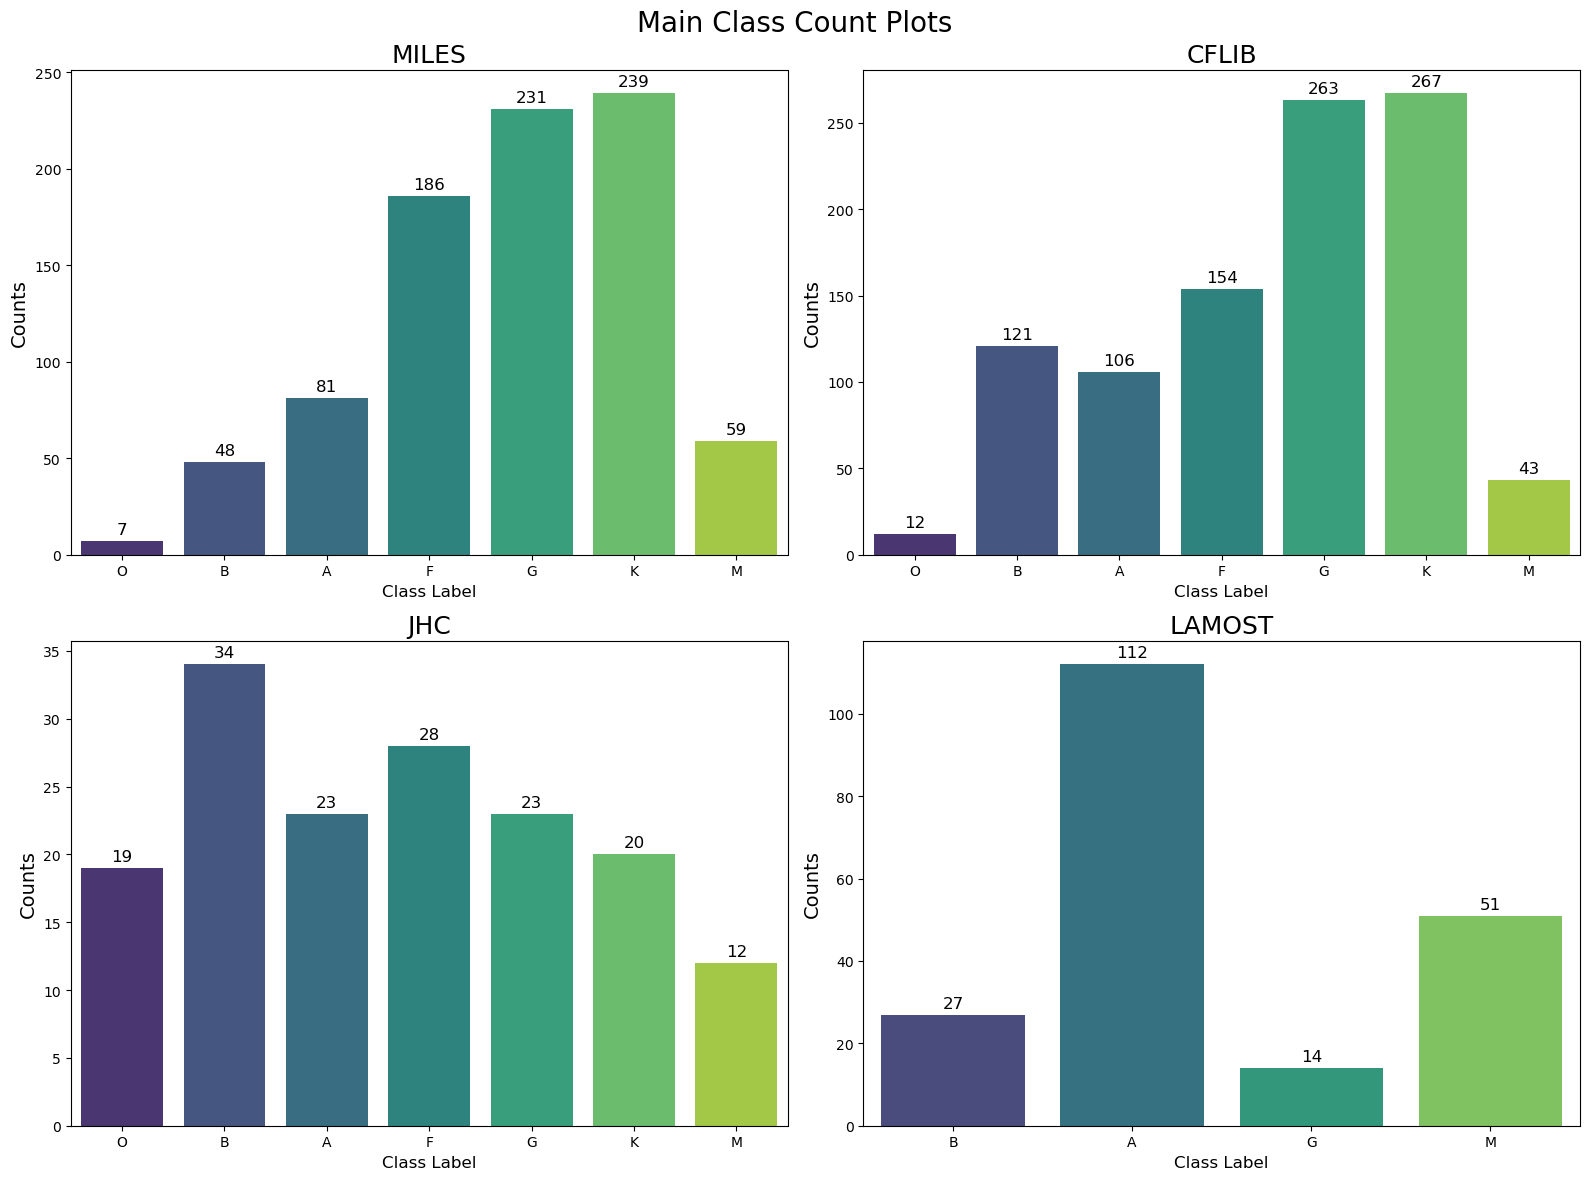

In [135]:
dataframes = [miles_spec, cflib_spec, jhc_spec, lamost_spec]
titles = ['MILES', 'CFLIB', 'JHC', 'LAMOST'] 
MK_main_class = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Create a 2x2 grid for the 4 dataframes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# flattening axes to iterate over them
axes = axes.flatten()
fig.suptitle('Main Class Count Plots', fontsize=20)

#looping through each dataframe
for i, df in enumerate(dataframes):
    #reordering subclass in order according to MK classes
    df['main_class'] = pd.Categorical(df['main_class'], categories=MK_main_class, ordered=True)

    #creating an number value for each main_class category for sorting
    df['main_class_order'] = df['main_class'].apply(lambda x: MK_main_class.index(x))

    #ordering by main_class then sub_class
    df = df.sort_values(by=['main_class_order'])
    df = df.reset_index().drop(columns='index')
    df['main_class'] = df['main_class'].astype(str)
    
    #creating plot
    ax = sns.countplot(x='main_class', data=df, palette='viridis', ax=axes[i])
    ax.set_title(f'{titles[i]}', fontsize=18)
    ax.set_xlabel('Class Label', fontsize=12)
    ax.set_ylabel('Counts', fontsize=14)
    
    # Annotating the bars with their respective counts
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', 
                    fontsize=12, color='black', xytext=(0, 5), 
                    textcoords='offset points')

# Adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

-------
# 5. Normalizing the Spectra

In [91]:
miles_spec.shape,  cflib_spec.shape, jhc_spec.shape, lamost_spec.shape, sdss_spec.shape

((851, 3), (966, 3), (159, 3), (204, 3), (962, 5))


In [68]:
#checking the length of each flux list in each dataframe
miles_spec['num_flux_values'] = miles_spec['flux'].apply(lambda x: len(x))
cflib_spec['num_flux_values'] = cflib_spec['flux'].apply(lambda x: len(x))
jhc_spec['num_flux_values'] = jhc_spec['flux'].apply(lambda x: len(x))
lamost_spec['num_flux_values'] = lamost_spec['flux'].apply(lambda x: len(x))
sdss_spec['num_flux_values'] = sdss_spec['flux'].apply(lambda x: len(x))

In [69]:
print(miles_spec['num_flux_values'].unique())
print(cflib_spec['num_flux_values'].unique())
print(jhc_spec['num_flux_values'].unique())
print(lamost_spec['num_flux_values'].unique())
print(sdss_spec['num_flux_values'].unique())

[4305]
[9681]
[2799]
[3349]
[3120]


- **Obesrvation:** I can see that the length of all flux values are consistent for each library

In [70]:
miles_spec = miles_spec.drop(columns=['num_flux_values'])
cflib_spec = cflib_spec.drop(columns=['num_flux_values'])
jhc_spec = jhc_spec.drop(columns=['num_flux_values'])
sdss_spec = sdss_spec.drop(columns=['num_flux_values'])

In [71]:
miles_wavelength = miles_wave.wavelength
miles_step = round((miles_wavelength[1] - miles_wavelength[0]),2)
print(f'MILES min: {min(miles_wavelength)}, max: {max(miles_wavelength)}, step: {miles_step}')

cflib_wavelength = cflib_wave.wavelength
cflib_step = round((cflib_wavelength[1] - cflib_wavelength[0]),2)
print(f'CFLIB min: {min(cflib_wavelength)}, max: {max(cflib_wavelength)}, step: {cflib_step}')

jhc_wavelength = jhc_wave.WAVELENGTH
jhc_step = round((jhc_wavelength[1] - jhc_wavelength[0]),2)
print(f'JHC min: {min(jhc_wavelength)}, max: {max(jhc_wavelength)}, step: {jhc_step}')

lamost_wavelength = lamost_wave.wavelength
lamost_step = round((lamost_wavelength[1] - lamost_wavelength[0]),2)
print(f'LAMOST min: {min(lamost_wavelength)}, max: {max(lamost_wavelength)}, step: {lamost_step}')

sdss_wavelength = sdss_wave.wavelength
sdss_step = round((sdss_wavelength[1] - sdss_wavelength[0]),2)
print(f'SDSS min: {min(sdss_wavelength)}, max: {max(sdss_wavelength)}, step: {sdss_step}')

MILES min: 3536.000000000004, max: 7409.600000000395, step: 0.9
CFLIB min: 3536.200000000016, max: 7408.200000000897, step: 0.4
JHC min: 3510.0, max: 7427.2, step: 1.4
LAMOST min: 3699.986328125, max: 7998.3447265625, step: 0.85
SDSS min: 3900.3176, max: 7998.3447, step: 0.9


**setting wavlength range as the maximum shared range available from the 4 data sources:**
3900.32 - 7408.2 Angstroms

## 5.1 Degrading spectra to same resolution

need to convolve all spectra to a common resolution.<br>
resolution values: 
 - JHC  = 4.5 Angstroms
 - MILES = 2.5 Angstroms
 - CFLIB = 1 Angstroms
 - LAMOST = 2.5 Angstroms
 - SDSS = 2.5 Angstroms

Since JHC has the lowest resolution of 4.5 A, this will be selected as the baseline resolution
ref: https://lotharschanne.wordpress.com/convolution-of-1d-spectra-with-gaussian-functions/


The width of the gaussian kernal to be applied to the gaussian filter is determined from the standard deviation of the filter - sigma. Using the resolution (FWHM) values this value can be converted to sigma using the formula: <br>
   - sigma = FWHM/2* sqrt(2log(2))
   
When you want to degrade the resolution of a spectrum, you need to convolve it with a Gaussian kernel whose width corresponds to the difference between the original and target resolutions.

ref to gaussian_filter1d: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter1d.html

In [72]:
def degrade_spectra(flux_values, current_res, baseline_res):
    if baseline_res <= current_res:
        #no degrading required for lowest resolution spectra
        return flux_values
    combined_res = np.sqrt((baseline_res**2) - (current_res**2))
    
    #the kernal width is determined from the standard deviation of the combined resolution
    kernal_width = combined_res/(2 * np.sqrt(2 * np.log(2)))
    
    flux_degraded = gaussian_filter1d(flux_values, kernal_width)
    return flux_degraded

In [73]:
##applying spectra degrading function to cflib and miles spectra
miles_spec['flux_degraded'] = miles_spec['flux'].apply(degrade_spectra, args=(2.5, 4.5))
cflib_spec['flux_degraded'] = cflib_spec['flux'].apply(degrade_spectra, args=(1, 4.5))
lamost_spec['flux_degraded'] = lamost_spec['flux'].apply(degrade_spectra, args=(2.5, 4.5))
sdss_spec['flux_degraded'] = sdss_spec['flux'].apply(degrade_spectra, args=(2.5, 4.5))

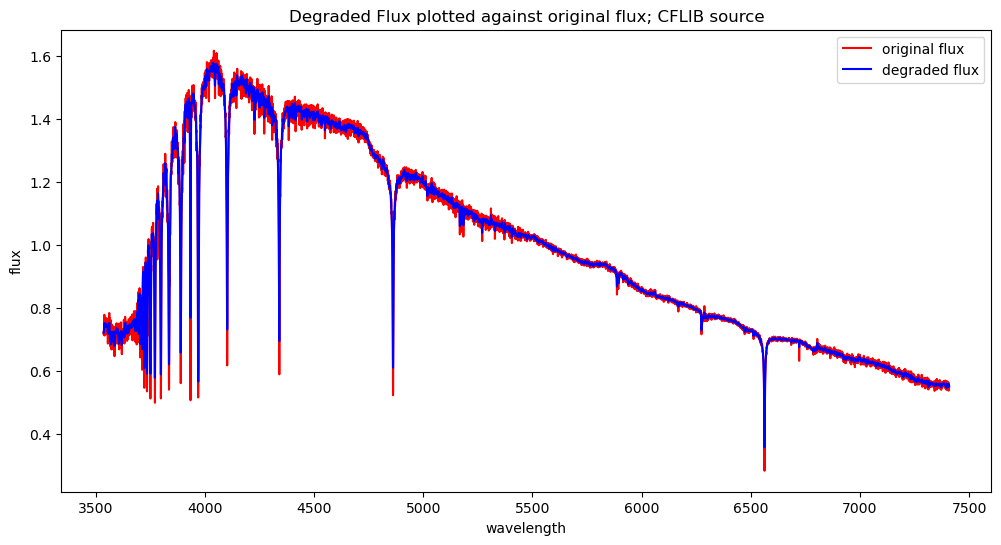

In [142]:
#plotting for CFLIB data
plt.figure(figsize=(12,6))
plt.plot(cflib_wavelength, cflib_spec['flux'][0], color='red', label='original flux')
plt.plot(cflib_wavelength, cflib_spec['flux_degraded'][0], color='blue', label='degraded flux')
plt.title('Degraded Flux plotted against original flux; CFLIB source')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()

#### Now all spectra are of the same resolution - could produce some plots to visualize
------

## 5.2 Interpolate Flux values to common wavelengths

Need to interpolate fluxes onto a common grid of wavelength values so that each feature in the models correspond to the same x axis values i.e. wavelengths. Thus allowing the spectra to be treated as 1 dimensional. <br>
In order to do this a common list of wavelength values is defined. The **cubic spline** function from scipy.interpolate is then used to interpolate the current fluxes to values at these selected wavelengths. <br>


The common wavelength list is defined between 3537 - 7408 Angstroms in steps of 1:

In [75]:
new_wavelengths = list(np.arange(3901, 7409, 1))

using the cubic spline interpolation from scipy.interpolate : https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html

In [76]:
def interpolate_flux(flux_values, wavelength_values):
    #creating list of common wavelengths
    new_wavlengths = list(np.arange(3901, 7409, 1))
    
    #initialising cubic spline function
    cubic_spline = CubicSpline(wavelength_values, flux_values)
    
    #applying to new wavlength list
    interpolated_flux = cubic_spline(new_wavlengths)
    return interpolated_flux

In [77]:
##applying cubic spline flux interpolation function across all flux values
miles_spec['flux_interpolated'] = miles_spec['flux_degraded'].apply(lambda x: interpolate_flux(x, miles_wavelength))
cflib_spec['flux_interpolated'] = cflib_spec['flux_degraded'].apply(lambda x: interpolate_flux(x, cflib_wavelength))
jhc_spec['flux_interpolated'] = jhc_spec['flux'].apply(lambda x: interpolate_flux(x, jhc_wavelength))
lamost_spec['flux_interpolated'] = lamost_spec['flux'].apply(lambda x: interpolate_flux(x, lamost_wavelength))
sdss_spec['flux_interpolated'] = sdss_spec['flux_degraded'].apply(lambda x: interpolate_flux(x, sdss_wavelength))

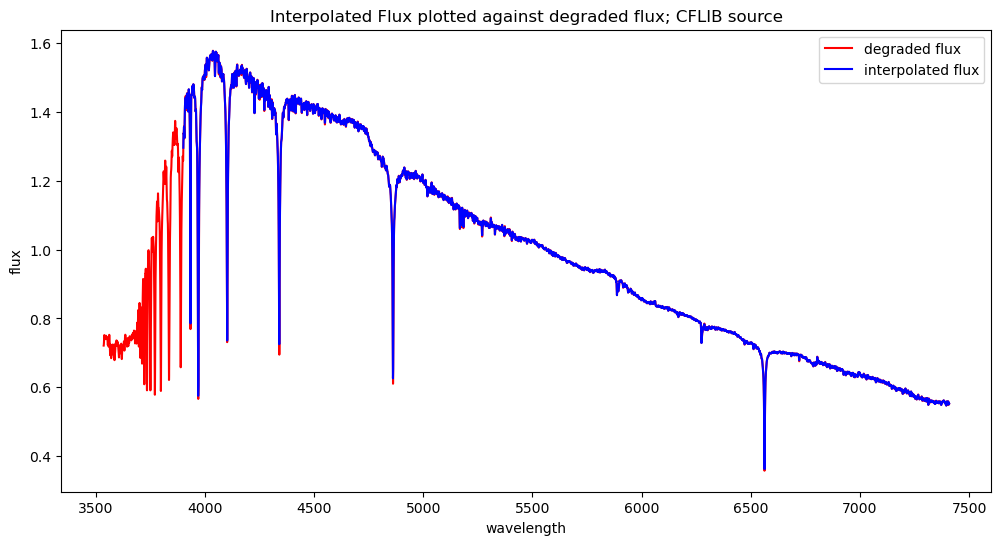

In [79]:
#plotting for MILES data
plt.figure(figsize=(12,6))
plt.plot(cflib_wavelength, cflib_spec['flux_degraded'][0], color='red', label='degraded flux')
plt.plot(new_wavelengths, cflib_spec['flux_interpolated'][0], color='blue', label='interpolated flux' )
plt.title('Interpolated Flux plotted against degraded flux; CFLIB source')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()

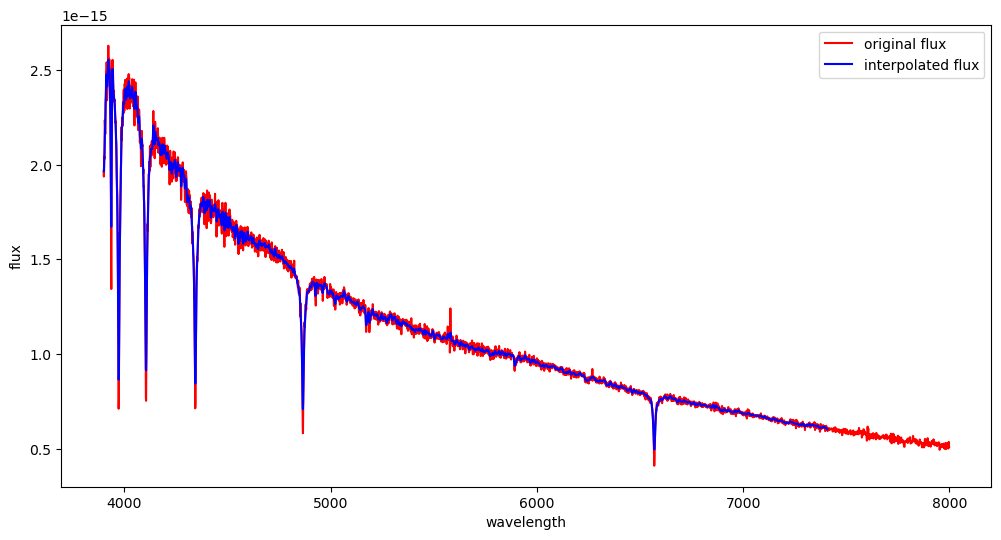

In [147]:
#plotting for sdss data
plt.figure(figsize=(12,6))
plt.plot(sdss_wavelength,sdss_spec['flux'].iloc[110],color='red', label='original flux')
plt.plot(new_wavelengths, sdss_spec['flux_interpolated'].iloc[110], color='blue', label='interpolated flux')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()

-------
## 5.3 Scaling the spectra 
bring all spectra to unity a specified wavelength value - choosing **5655** as this is the median of the wavelength range. There I want to divide all values by the flux value at this wavelength.


#### Looking at the distribution of flux values: 

<Axes: ylabel='Count'>

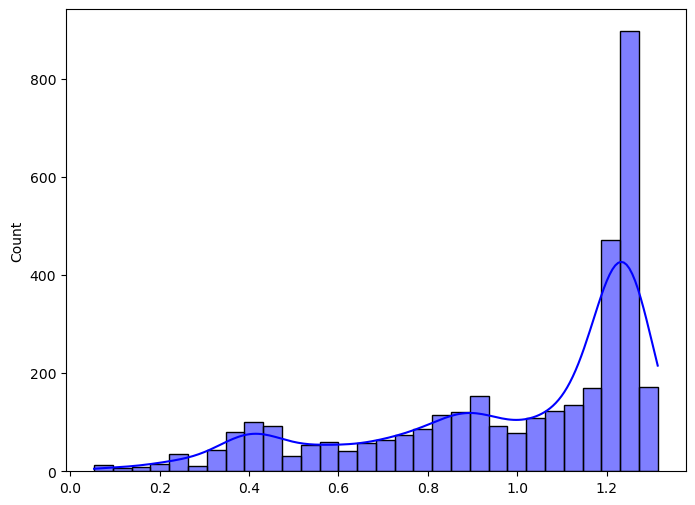

In [80]:
#getting the distribution of flux values
dt = miles_spec['flux_interpolated'][1]
plt.figure(figsize=(8, 6))
sns.histplot(dt, kde=True, bins=30, color='blue')

In [81]:
#getting index of this wavelength
unity_index = new_wavelengths.index(5655)

In [82]:
def normalize_spectra(flux_values, unity_index):
    #getting the flux value at specified wavelength
    unity_flux = flux_values[unity_index]
    #dividing all values in the flux list by this flux value
    normalized_flux = [x / unity_flux for x in flux_values]
    return normalized_flux

In [83]:
##applying cubic spline flux interpolation function across all flux values
miles_spec['flux_normalized'] = miles_spec['flux_interpolated'].apply(lambda x: normalize_spectra(x, unity_index))
cflib_spec['flux_normalized'] = cflib_spec['flux_interpolated'].apply(lambda x: normalize_spectra(x, unity_index))
jhc_spec['flux_normalized'] = jhc_spec['flux_interpolated'].apply(lambda x: normalize_spectra(x, unity_index))
lamost_spec['flux_normalized'] = lamost_spec['flux_interpolated'].apply(lambda x: normalize_spectra(x, unity_index))
sdss_spec['flux_normalized'] = sdss_spec['flux_interpolated'].apply(lambda x: normalize_spectra(x, unity_index))

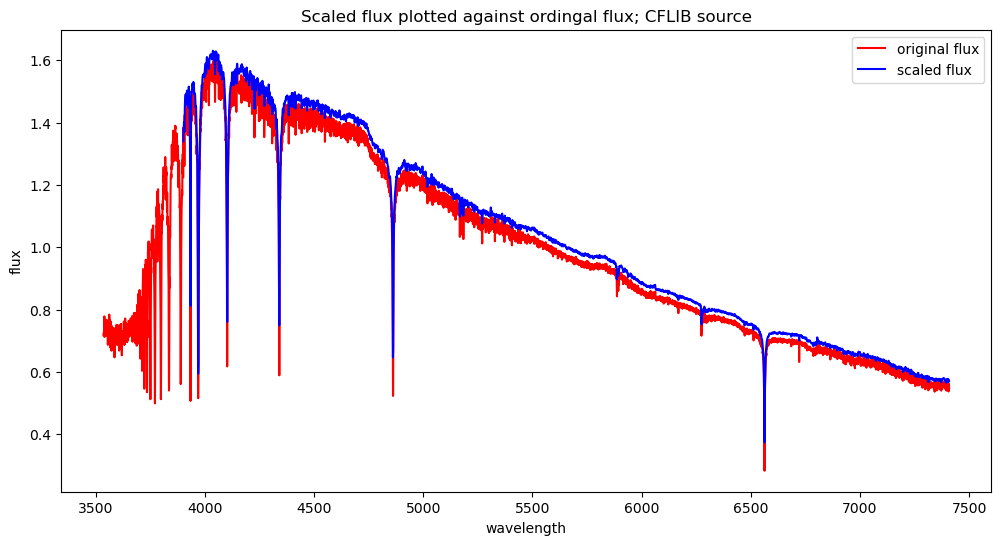

In [84]:
#plotting for MILES data
plt.figure(figsize=(12,6))
plt.plot(cflib_wavelength, cflib_spec['flux'][0], color='red', label='original flux')
plt.plot(new_wavelengths, cflib_spec['flux_normalized'][0], color='blue', label='scaled flux' )
plt.title('Scaled flux plotted against ordingal flux; CFLIB source')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()

-------
## 6. Comparing spectra of similar subclasses to ensure spectra look similar after all processing done

In [99]:
A_jhc = jhc_spec[jhc_spec['sub_class']=='A7'].flux_normalized[0]
A_cflib = cflib_spec[cflib_spec['sub_class']=='A7'].flux_normalized[0]
A_miles = miles_spec[miles_spec['sub_class']=='A7'].flux_normalized[0]
A_lamost = lamost_spec[lamost_spec['sub_class']=='A7'].flux_normalized.iloc[0]

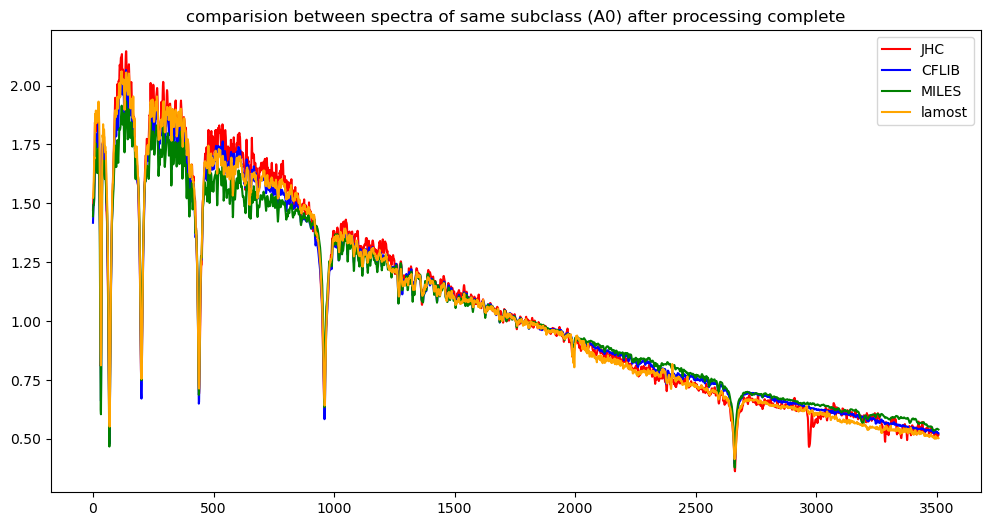

In [100]:
plt.figure(figsize=(12,6))
plt.title('comparision between spectra of same subclass (A0) after processing complete')
plt.plot(A_jhc, color = 'red', label='JHC')
plt.plot(A_cflib, color = 'blue', label='CFLIB')
plt.plot(A_miles, color = 'green', label='MILES')
plt.plot(A_lamost, color = 'orange', label='lamost')
plt.legend()
plt.show()

In [101]:
B_jhc = jhc_spec[jhc_spec['sub_class']=='B6'].flux_normalized[0]
B_cflib = cflib_spec[cflib_spec['sub_class']=='B6'].flux_normalized[0]
B_miles = miles_spec[miles_spec['sub_class']=='B6'].flux_normalized[0]
B_lamost = lamost_spec[lamost_spec['sub_class']=='B6'].flux_normalized.iloc[0]

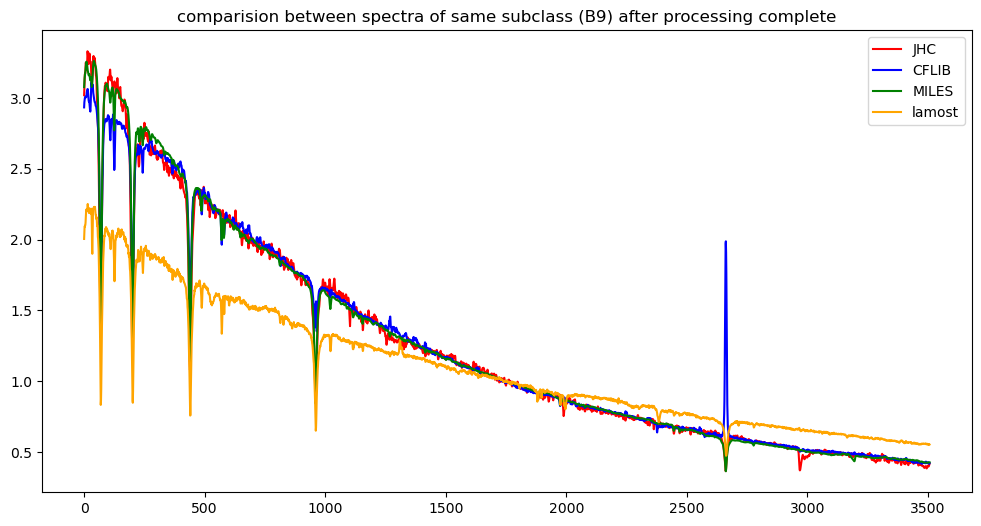

In [102]:
plt.figure(figsize=(12,6))
plt.title('comparision between spectra of same subclass (B9) after processing complete')
plt.plot(B_jhc, color = 'red', label='JHC')
plt.plot(B_cflib, color = 'blue', label='CFLIB')
plt.plot(B_miles, color = 'green', label='MILES')
plt.plot(B_lamost, color = 'orange', label='lamost')
plt.legend()
plt.show()

In [103]:
M_jhc = jhc_spec[jhc_spec['sub_class']=='M2'].flux_normalized[0]
M_cflib = cflib_spec[cflib_spec['sub_class']=='M2'].flux_normalized[0]
M_miles = miles_spec[miles_spec['sub_class']=='M2'].flux_normalized[0]
M_lamost = lamost_spec[lamost_spec['sub_class']=='M2'].flux_normalized.iloc[0]

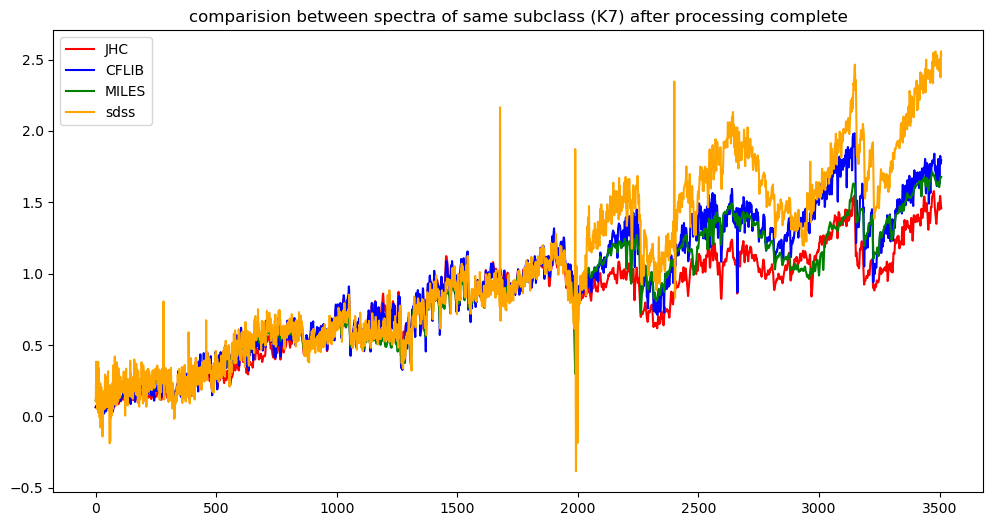

In [104]:
plt.figure(figsize=(12,6))
plt.title('comparision between spectra of same subclass (K7) after processing complete')
plt.plot(M_jhc, color = 'red', label='JHC')
plt.plot(M_cflib, color = 'blue', label='CFLIB')
plt.plot(M_miles, color = 'green', label='MILES')
plt.plot(M_lamost, color = 'orange', label='sdss')
plt.legend()
plt.show()

-------
## 7. removing unnecessary columns and merging datasets

In [155]:
cflib_spec = cflib_spec[['main_class', 'sub_class', 'flux_normalized']]
miles_spec = miles_spec[['main_class', 'sub_class', 'flux_normalized']]
jhc_spec = jhc_spec[['main_class', 'sub_class', 'flux_normalized']]
lamost_spec = lamost_spec[['main_class', 'sub_class', 'flux_normalized']]

sdss_spec = sdss_spec.drop(columns=['flux', 'flux_degraded', 'flux_interpolated'])
sdss_spec = sdss_spec.rename(columns={'flux_normalized':'flux'})

**NOTE**: for merging datasets, all spectral libraries (i.e. cflib, miles, jhc, lamost) will be merged together for use in modelling, whilst SDSS data will be kept seperately as this will be used for testing generalizability of best model as outlined in project research objectives.  

In [156]:
#merging all spectra libraries for model training
all_spec_libs = pd.concat([cflib_spec, miles_spec, jhc_spec, lamost_spec]).reset_index().drop(columns=('index'))
all_spec_libs = all_spec_libs.rename(columns={'flux_normalized':'flux'})
all_spec_libs.head()

,main_class,sub_class,flux
0,F,F0,"[1.3396607989825384, 1.3819171734622744, 1.380..."
1,G,G8,"[0.3914051383862435, 0.380001721020687, 0.3195..."
2,G,G6,"[0.4154833555445214, 0.40423242022031103, 0.38..."
3,G,G6,"[0.46483637887919615, 0.4533931441521057, 0.39..."
4,G,G5,"[0.8268445673426712, 0.732478586791271, 0.7376..."


In [157]:
wavelengths = pd.DataFrame({'wavelength':new_wavelengths})

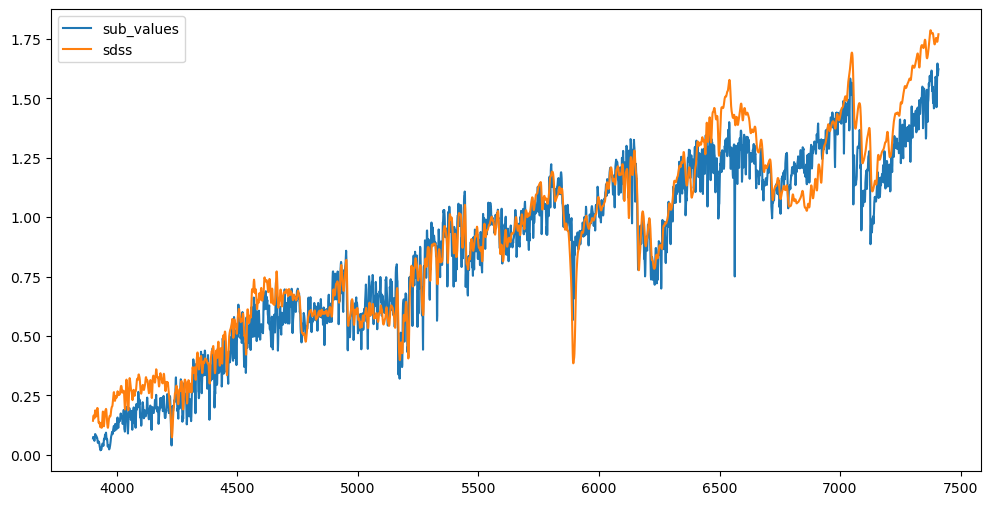

In [108]:
sub_sdss_values = sdss_spec[sdss_spec['sub_class'] == 'M1'].flux.values[1]
sub_values = all_spec_libs[all_spec_libs['sub_class'] == 'M1'].flux.values[1]

plt.figure(figsize=(12,6))

plt.plot(wavelengths, sub_values, label='sub_values')
plt.plot(wavelengths, sub_sdss_values, label='sdss')

plt.legend()

In [109]:
sdss_spec['sub_class'].unique()

array(['O', 'B9', 'B6', 'A0', 'F5', 'F9', 'F2', 'G2', 'G0', 'K7', 'K3',
       'K5', 'K1', 'M0', 'M2', 'M1', 'M3', 'M4'], dtype=object)

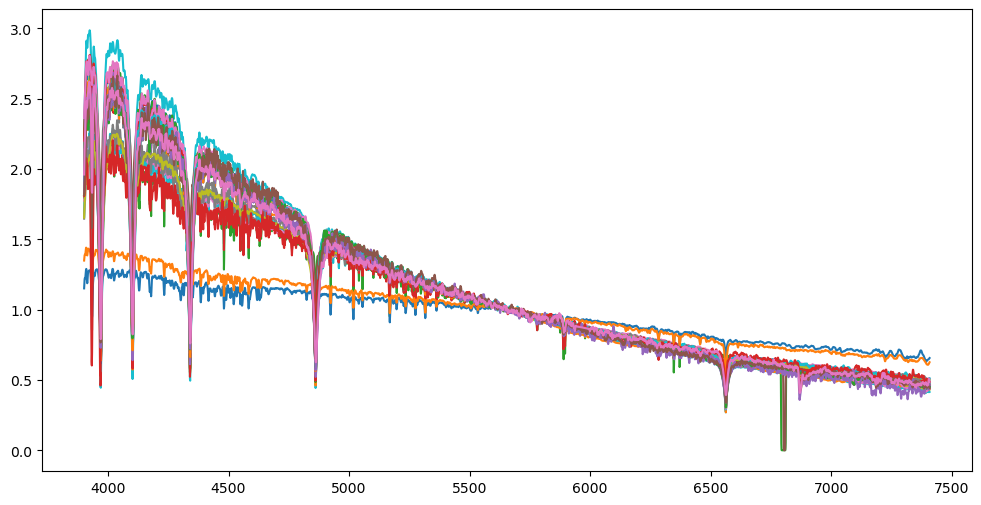

In [116]:
sub_values = all_spec_libs[all_spec_libs['sub_class'] == 'A2'].flux.values

plt.figure(figsize=(12,6))
for i in range(len(sub_values)):
    flux = sub_values[i]
    plt.plot(wavelengths, flux)

In [177]:
all_spec_libs.head()

,main_class,sub_class,flux
0,F,F0,"[1.3396607989825384, 1.3819171734622744, 1.380..."
1,G,G8,"[0.3914051383862435, 0.380001721020687, 0.3195..."
2,G,G6,"[0.4154833555445214, 0.40423242022031103, 0.38..."
3,G,G6,"[0.46483637887919615, 0.4533931441521057, 0.39..."
4,G,G5,"[0.8268445673426712, 0.732478586791271, 0.7376..."


## Plotting a spectrum for each MK Class

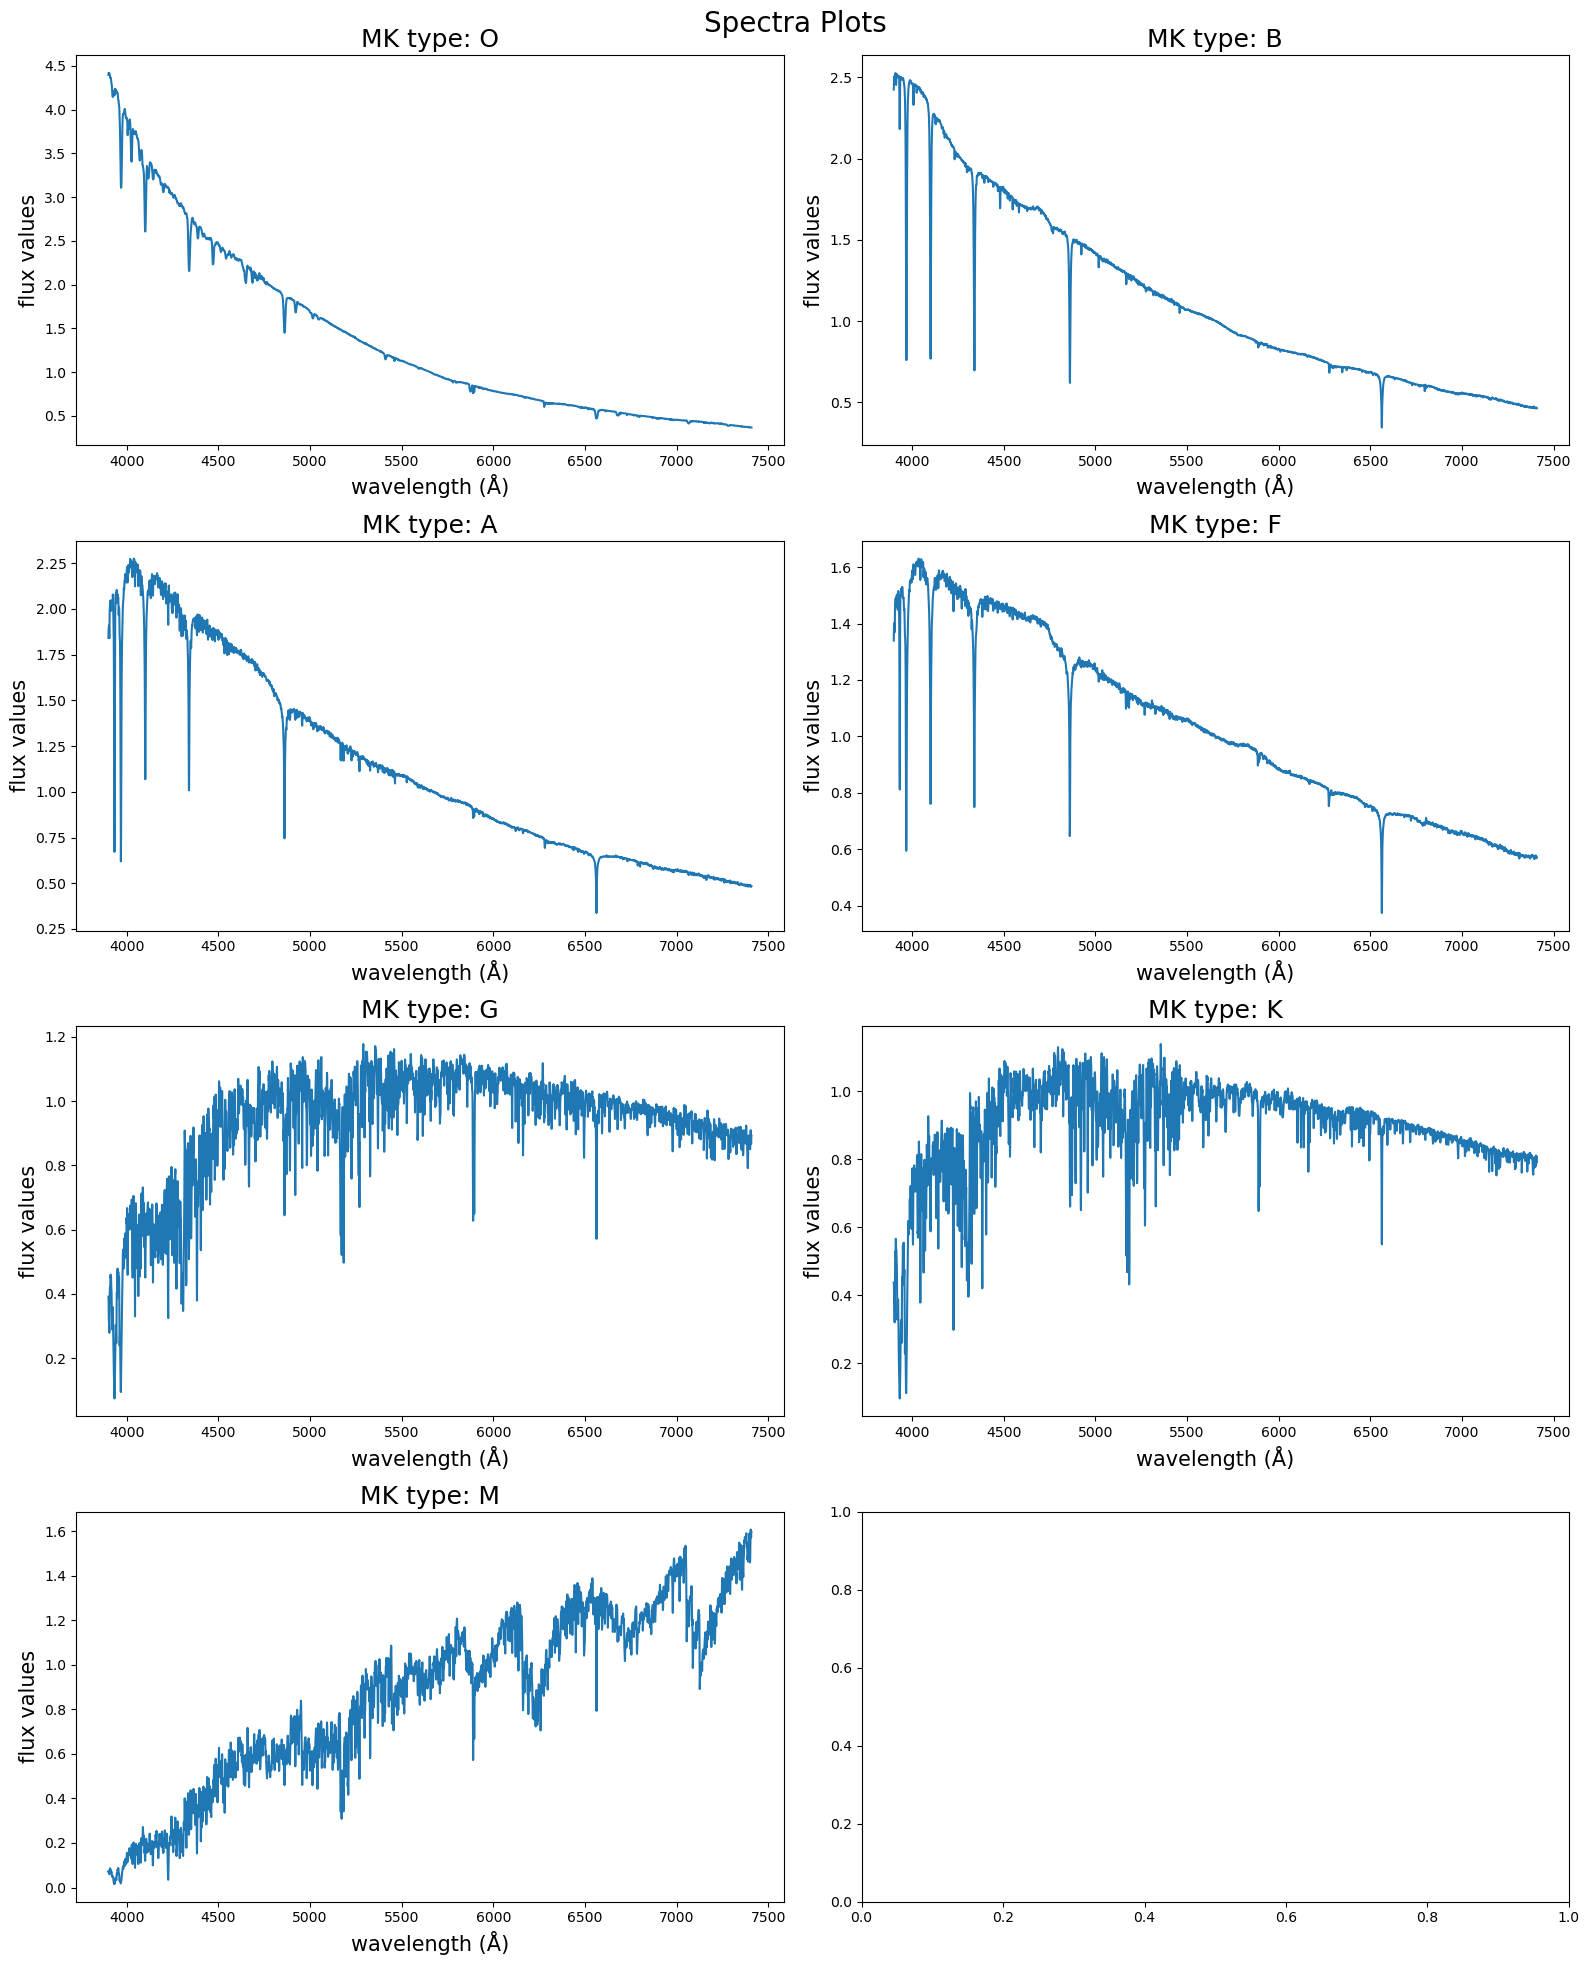

In [176]:
##looking at spectra shapes for all 7 MK classess
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
plot_indices = [0,0,1,1,2,2,3]

for i, sp_type in enumerate(['O', 'B', 'A','F','G','K','M']):
    
    #selecting one star from each main class
    data = all_spec_libs[all_spec_libs['main_class']==sp_type].reset_index().iloc[0]
    spec_type = data.main_class
    flux = data.flux
    
    #determining what axes to plot
    #(using mod, means that the first plot will be axes[0, 0], second [0, 1], third [1, 0 ] and so on)
    b = (i + 2) % 2
    a = plot_indices[i]

    sns.lineplot(x=wavelengths['wavelength'].values, y=flux, ax=axes[a, b])
    axes[a, b].set_title(f'MK type: {spec_type}', fontsize=18)
    axes[a, b].set_xlabel('wavelength (Å)', fontsize=15)
    axes[a, b].set_ylabel(f'flux values',fontsize=15)
    
plt.suptitle('Spectra Plots', fontsize=20)
plt.tight_layout()
plt.show() 

## 8. saving processed data to pickle files to be loaded into model notebooks

In [154]:
#saving to derived_tables directory as pickle file
all_spec_libs.to_pickle('../data/derived_tables/all_spec_libs.pkl')

In [155]:
#saving SDSS data seperately
sdss_spec.to_pickle('../data/derived_tables/sdss_spec.pkl')

In [156]:
#wavelengths = pd.DataFrame({'wavelength':new_wavelengths})
wavelengths.to_csv('../data/derived_tables/wavelengths.csv')

In [195]:
##load in cleaned and processed data
all_spec = pd.read_pickle('../data/derived_tables/all_spec_libs.pkl')

#loading in the wavelength values and setting to list for plotting purposes
wavelengths = pd.read_csv('../data/derived_tables/wavelengths.csv', index_col=0)
wavelengths = list(wavelengths['wavelength'])

In [196]:
#all_spec = all_spec.dropna()

In [197]:
all_spec.head()

,main_class,sub_class,flux
0,F,F0,"[1.3396607989825384, 1.3819171734622744, 1.380..."
1,G,G8,"[0.3914051383862435, 0.380001721020687, 0.3195..."
2,G,G6,"[0.4154833555445214, 0.40423242022031103, 0.38..."
3,G,G6,"[0.46483637887919615, 0.4533931441521057, 0.39..."
4,G,G5,"[0.8268445673426712, 0.732478586791271, 0.7376..."


In [198]:
#reordering subclass in order according to MK classes
MK_main_class = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
all_spec['main_class'] = pd.Categorical(all_spec['main_class'], categories=MK_main_class, ordered=True)

#creating a new column with subclass number for sorting
all_spec['sub_class_number'] = all_spec['sub_class'].str.extract('(\d+)')

In [199]:
#creating an number value for each main_class category for sorting
all_spec['main_class_order'] = all_spec['main_class'].apply(lambda x: MK_main_class.index(x))

In [200]:
#ordering by main_class then sub_class
all_spec = all_spec.sort_values(by=['main_class_order', 'sub_class_number'])

In [201]:
all_spec = all_spec.drop(columns=['sub_class_number', 'main_class_order'])

In [202]:
all_spec = all_spec.reset_index().drop(columns='index')

In [203]:
all_spec['main_class'] = all_spec['main_class'].astype(str)

In [204]:
all_spec.head()

,main_class,sub_class,flux
0,O,O5,"[4.133800648310878, 4.1399905631340435, 4.1395..."
1,O,O5,"[4.305689743205644, 4.285180456914326, 4.28150..."
2,O,O5,"[4.123800648310878, 4.129990563134044, 4.12955..."
3,O,O5,"[4.293389743205644, 4.272880456914327, 4.26920..."
4,O,O5,"[4.121500648310878, 4.127690563134044, 4.12725..."


## 9. Preparation for main class classification

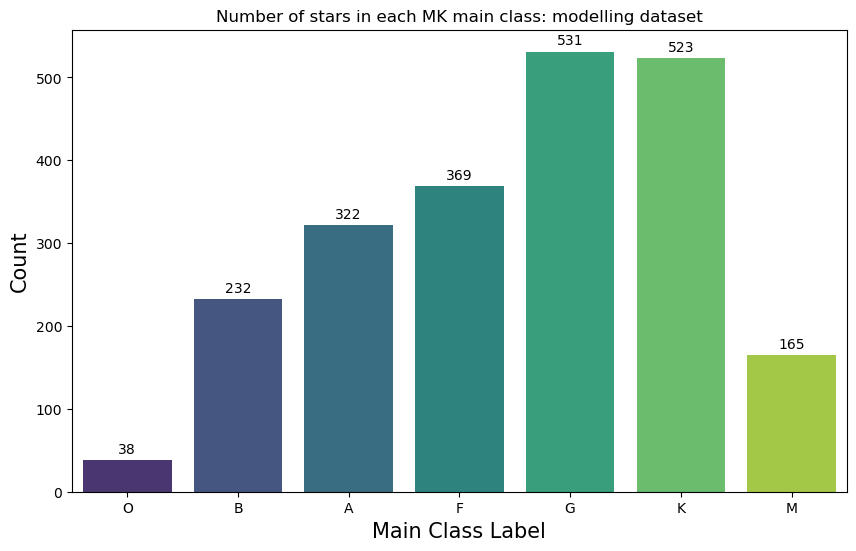

In [205]:
#having a quick look at the class balance
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='main_class', data=all_spec, palette='viridis')
plt.title('Number of stars in each MK main class: modelling dataset')
plt.xlabel('Main Class Label', fontsize=15)
plt.ylabel('Count', fontsize=15)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

In [206]:
##reformatting the data so it can be used to train each model
#selecting the two columns required for these models
main_class = all_spec[['main_class','flux']]

#since each flux value is an individual feature, the dataframe needs to be reformatted such that each flux value is a column
flux_data = pd.DataFrame(main_class['flux'].tolist(), index=main_class.index)
flux_data.columns = [f'flux_{i}' for i in range(flux_data.shape[1])]

main_class = pd.concat([main_class['main_class'],flux_data],axis=1)
main_class.head()

,main_class,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,...,flux_3498,flux_3499,flux_3500,flux_3501,flux_3502,flux_3503,flux_3504,flux_3505,flux_3506,flux_3507
0,O,4.133801,4.139991,4.139556,4.129070,4.118934,4.124957,4.147676,4.146354,4.109543,...,0.337624,0.338857,0.340129,0.340838,0.341425,0.341392,0.339566,0.335772,0.332557,0.331071
1,O,4.305690,4.285180,4.281510,4.300601,4.307797,4.284261,4.281621,4.278348,4.254337,...,0.389051,0.389987,0.391664,0.391300,0.387997,0.386858,0.389578,0.391623,0.385380,0.379857
2,O,4.123801,4.129991,4.129556,4.119070,4.108934,4.114957,4.137676,4.136354,4.099543,...,0.327624,0.328857,0.330129,0.330838,0.331425,0.331392,0.329566,0.325772,0.322557,0.321071
3,O,4.293390,4.272880,4.269210,4.288301,4.295497,4.271961,4.269321,4.266048,4.242037,...,0.376751,0.377687,0.379364,0.379000,0.375697,0.374558,0.377278,0.379323,0.373080,0.367557
4,O,4.121501,4.127691,4.127256,4.116770,4.106634,4.112657,4.135376,4.134054,4.097243,...,0.325324,0.326557,0.327829,0.328538,0.329125,0.329092,0.327266,0.323472,0.320257,0.318771


In [207]:
main_class.shape

(2180, 3509)

## 9.1 Encoding and saving X and y for main class classification:

**NOTE**: Due to the ordinal nature of the target variables, I want to encode these corresponding to their natural order and handle this as an ordinal classification task: 
- file:///C:/Users/gerar/Downloads/applsci-12-01815-v3.pdf
- https://link.springer.com/chapter/10.1007/978-3-642-01818-3_25

In [208]:
encoded_data = main_class.copy()

In [209]:
class_order = encoded_data['main_class'].unique()

In [210]:
class_mapping = {label: idx for idx, label in enumerate(class_order)}

In [211]:
encoded_data['main_class'] = encoded_data['main_class'].map(class_mapping)

In [212]:
encoded_data['main_class'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [213]:
encoded_data.to_csv('../data/derived_tables/X_y_data/main_class_data.csv')

## 10. Preparing data for sub-class classification models

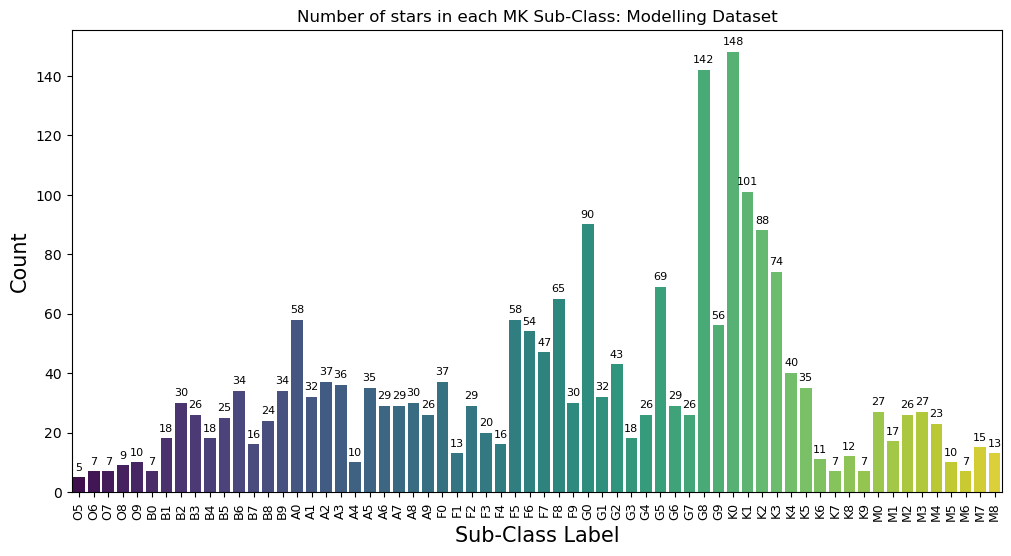

In [418]:
#having a quick look at the class balance
plt.figure(figsize=(12, 6))
ax= sns.countplot(x='sub_class', data=all_spec, palette='viridis')
plt.title('Number of stars in each MK Sub-Class: Modelling Dataset')
plt.xlabel('Sub-Class Label', fontsize=15)
plt.ylabel('Count', fontsize=15)

plt.xticks(rotation=90, fontsize=9)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', 
                fontsize=8, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

In [419]:
##reformatting the data so it can be used to train each model
#selecting the two columns required for these models
sub_class = all_spec[['sub_class','flux']]

#since each flux value is an individual feature, the dataframe needs to be reformatted such that each flux value is a column
flux_data = pd.DataFrame(sub_class['flux'].tolist(), index=sub_class.index)
flux_data.columns = [f'flux_{i}' for i in range(flux_data.shape[1])]

sub_class = pd.concat([sub_class['sub_class'],flux_data],axis=1)
sub_class.head()

,sub_class,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,...,flux_3498,flux_3499,flux_3500,flux_3501,flux_3502,flux_3503,flux_3504,flux_3505,flux_3506,flux_3507
0,O5,4.133801,4.139991,4.139556,4.129070,4.118934,4.124957,4.147676,4.146354,4.109543,...,0.337624,0.338857,0.340129,0.340838,0.341425,0.341392,0.339566,0.335772,0.332557,0.331071
1,O5,4.305690,4.285180,4.281510,4.300601,4.307797,4.284261,4.281621,4.278348,4.254337,...,0.389051,0.389987,0.391664,0.391300,0.387997,0.386858,0.389578,0.391623,0.385380,0.379857
2,O5,4.123801,4.129991,4.129556,4.119070,4.108934,4.114957,4.137676,4.136354,4.099543,...,0.327624,0.328857,0.330129,0.330838,0.331425,0.331392,0.329566,0.325772,0.322557,0.321071
3,O5,4.293390,4.272880,4.269210,4.288301,4.295497,4.271961,4.269321,4.266048,4.242037,...,0.376751,0.377687,0.379364,0.379000,0.375697,0.374558,0.377278,0.379323,0.373080,0.367557
4,O5,4.121501,4.127691,4.127256,4.116770,4.106634,4.112657,4.135376,4.134054,4.097243,...,0.325324,0.326557,0.327829,0.328538,0.329125,0.329092,0.327266,0.323472,0.320257,0.318771


In [420]:
#checking for values
sub_class.isnull().sum()

sub_class    0
flux_0       0
flux_1       0
flux_2       0
flux_3       0
            ..
flux_3503    0
flux_3504    0
flux_3505    0
flux_3506    0
flux_3507    0
Length: 3509, dtype: int64

## 10.1 Encoding and saving X and y for sub-class classification:

In [426]:
encoded_data = sub_class.copy()

In [427]:
class_order = encoded_data['sub_class'].unique()

In [428]:
class_mapping_sub_class = {label: idx for idx, label in enumerate(class_order)}

In [429]:
encoded_data['sub_class'] = encoded_data['sub_class'].map(class_mapping_sub_class)

In [430]:
encoded_data.head()

,sub_class,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,...,flux_3498,flux_3499,flux_3500,flux_3501,flux_3502,flux_3503,flux_3504,flux_3505,flux_3506,flux_3507
0,0,4.133801,4.139991,4.139556,4.129070,4.118934,4.124957,4.147676,4.146354,4.109543,...,0.337624,0.338857,0.340129,0.340838,0.341425,0.341392,0.339566,0.335772,0.332557,0.331071
1,0,4.305690,4.285180,4.281510,4.300601,4.307797,4.284261,4.281621,4.278348,4.254337,...,0.389051,0.389987,0.391664,0.391300,0.387997,0.386858,0.389578,0.391623,0.385380,0.379857
2,0,4.123801,4.129991,4.129556,4.119070,4.108934,4.114957,4.137676,4.136354,4.099543,...,0.327624,0.328857,0.330129,0.330838,0.331425,0.331392,0.329566,0.325772,0.322557,0.321071
3,0,4.293390,4.272880,4.269210,4.288301,4.295497,4.271961,4.269321,4.266048,4.242037,...,0.376751,0.377687,0.379364,0.379000,0.375697,0.374558,0.377278,0.379323,0.373080,0.367557
4,0,4.121501,4.127691,4.127256,4.116770,4.106634,4.112657,4.135376,4.134054,4.097243,...,0.325324,0.326557,0.327829,0.328538,0.329125,0.329092,0.327266,0.323472,0.320257,0.318771


In [431]:
#number of categories
len(encoded_data['sub_class'].unique())

64

In [227]:
#saving X and y to csvs
encoded_data.to_csv('../data/derived_tables/X_y_data/sub_class_data.csv')

# 11. Creating a balanced dataset

**As can be seen from both the main class and sub class cases, there is a substantial class imbalance.
Due to the dominance of some majority classes, this could lead to substantial model bias, therefore a combination of undersampling and oversampling will be utilised to bring the dataset to a more balanced version:**

Notes on handling class imbalance: <br>
**SMOTE:**
- https://machinelearningmastery.com/multi-class-imbalanced-classification/ 

- *In extreme cases where the number of observations in the rare class(es) is really small, oversampling is better, as you will not lose important information on the distribution of the other classes in the datas* - https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data


- https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

- https://towardsdatascience.com/stop-using-smote-to-treat-class-imbalance-take-this-intuitive-approach-instead-9cb822b8dc45

- https://towardsdatascience.com/how-to-handle-multiclass-imbalanced-data-say-no-to-smote-e9a7f393c310 - suggests limitations of SMOTE when used with high dimensional data

## 11.1 handling sub class case: 

In [434]:
sub_class_counts = all_spec['sub_class'].value_counts()

all_spec['sub_class_counts'] = pd.Categorical(all_spec['sub_class'], categories=sub_class_counts.index, ordered=True)

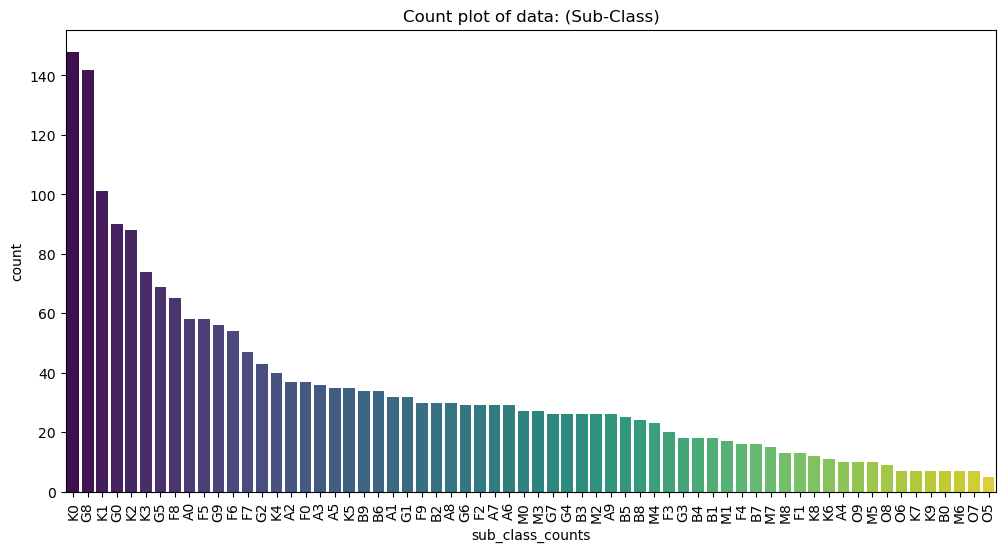

In [435]:
#having a quick look at the class balance
plt.figure(figsize=(12, 6))
sns.countplot(x='sub_class_counts', data=all_spec, palette='viridis')
plt.title('Count plot of data: (Sub-Class)')
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [436]:
sample_counts = Counter(all_spec['sub_class'])
sample_counts = list(sample_counts.values())

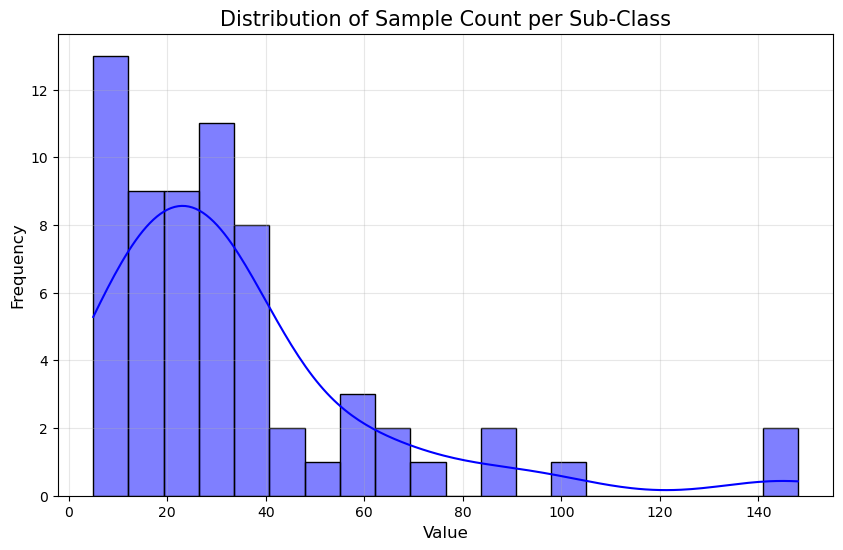

In [437]:
#plotting distribution of sample count per sub-Class
plt.figure(figsize=(10, 6))
sns.histplot(sample_counts, bins=20, kde=True, color='blue', edgecolor='black')

plt.title('Distribution of Sample Count per Sub-Class', fontsize=15)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [438]:
#creating a dataframe relating to the count of each sub class values
sub_class_counts = all_spec['sub_class'].value_counts()
sub_class_counts = sub_class_counts.reset_index()
sub_class_counts.columns = ['sub_class', 'count']

In [439]:
mean_counts = round(np.mean(sub_class_counts['count']))
median_counts = round(np.median(sub_class_counts['count']))
print(f'Mean number of samples for each sub class: {mean_counts}')
print(f'Median number of samples for each sub class: {median_counts}')

Mean number of samples for each sub class: 34
Median number of samples for each sub class: 27


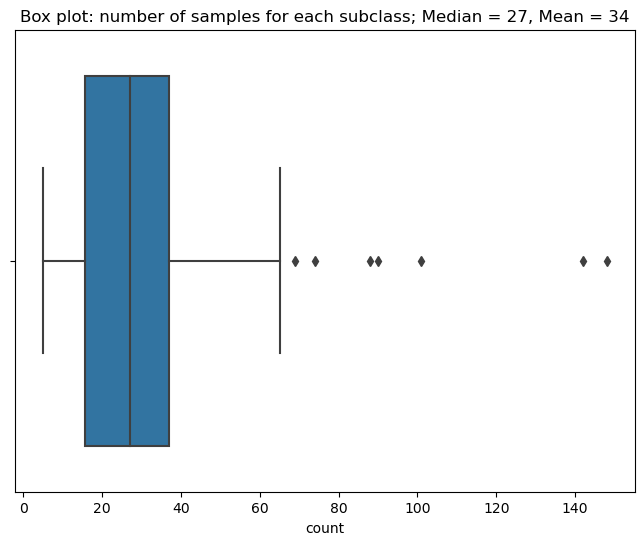

In [440]:
#creating a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=sub_class_counts['count'])
plt.title('Box plot: number of samples for each subclass; Median = 27, Mean = 34')
plt.show()

### 11.1.1 Undersampling majority classes down to a level that is more representative of the sample count distribution (i.e. Median value- due to the skewed distribution)

In [441]:
#getting the main, sub class and flux values
data = all_spec[['main_class', 'sub_class','flux']]

# the dataframe needs to be reformatted such that each flux value is a column
flux_data = pd.DataFrame(data['flux'].tolist(), index=data.index)
flux_data.columns = [f'flux_{i}' for i in range(flux_data.shape[1])]

data = pd.concat([data['main_class'], data['sub_class'],flux_data],axis=1)

In [442]:
sub_class_bal = data.drop(columns=['main_class'])

In [443]:
#splitting into independent/input (X) and dependent/target (Y) variables
X_sub_bal = sub_class_bal.loc[:, sub_class_bal.columns != 'sub_class']
y_sub_bal = sub_class_bal.loc[:, 'sub_class']

In [444]:
#getting the counts in each class
class_counts = pd.Series(y_sub_bal).value_counts()
#setting threshold to 34 samples
threshold = 27
#creating a dictionary mapping thresholds to each sp_type
sampling_strategy = {sp_type: threshold for sp_type in class_counts[class_counts > threshold].index}

In [445]:
#initialising the randomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)

In [446]:
#fitting the undersamplers
X_sub_bal, y_sub_bal = rus.fit_resample(X_sub_bal, y_sub_bal)

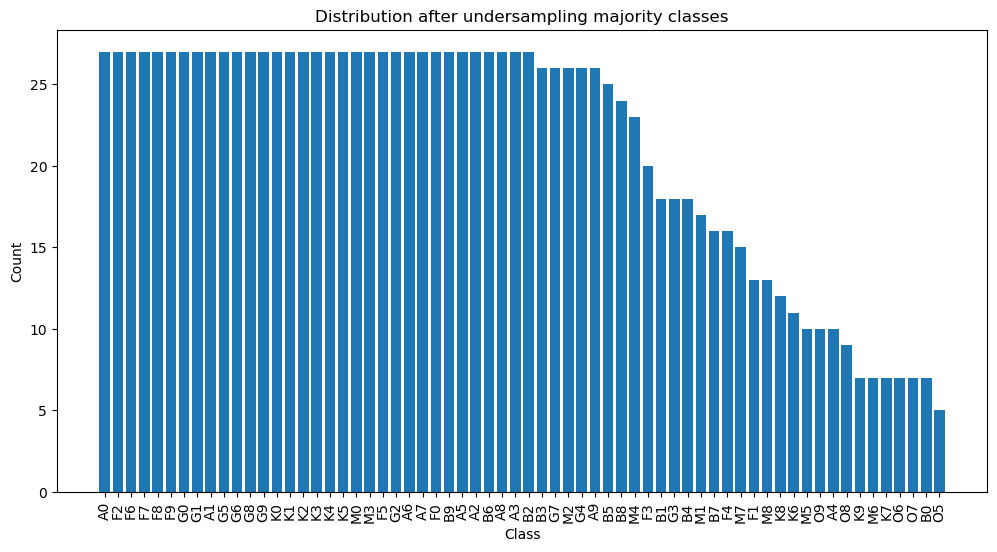

In [447]:
sub_class_counts = y_sub_bal.value_counts()

classes = sub_class_counts.index
counts = sub_class_counts.values

# Plot
plt.figure(figsize=(12, 6))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution after undersampling majority classes')
plt.xticks(rotation=90)
plt.show()

### 11.1.2 Utilising SMOTE oversampling technique to balance the minority classes

In [448]:
# transform the dataset
oversample = SMOTE(random_state = 42, k_neighbors=1)
X_sub_bal, y_sub_bal = oversample.fit_resample(X_sub_bal, y_sub_bal)

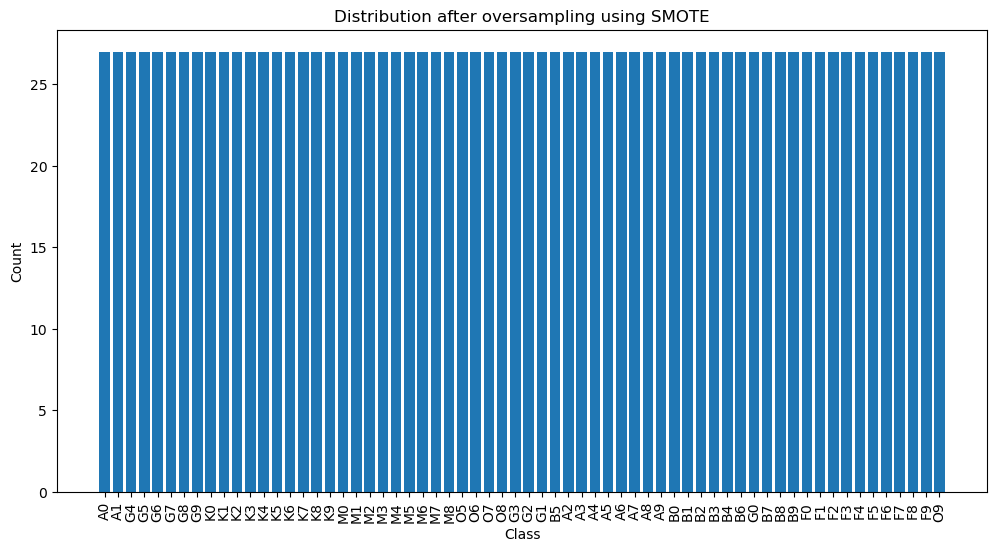

In [449]:
sub_class_counts = y_sub_bal.value_counts()

classes = sub_class_counts.index
counts = sub_class_counts.values

# Plot
plt.figure(figsize=(12, 6))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution after oversampling using SMOTE')
plt.xticks(rotation=90)
plt.show()

In [456]:
#merging X and y for simplicity in terms of saving 
sub_bal = pd.merge(y_sub_bal, X_sub_bal, left_index=True, right_index=True)

In [458]:
#reordering to original ordering (i.e O -> B -> A etc.)
order = sub_class['sub_class'].unique()
sub_bal['sub_class'] = pd.Categorical(sub_bal['sub_class'], categories=order, ordered=True)
sub_bal = sub_bal.sort_values('sub_class').reset_index(drop=True)
sub_bal['sub_class'] = sub_bal['sub_class'].astype('object')

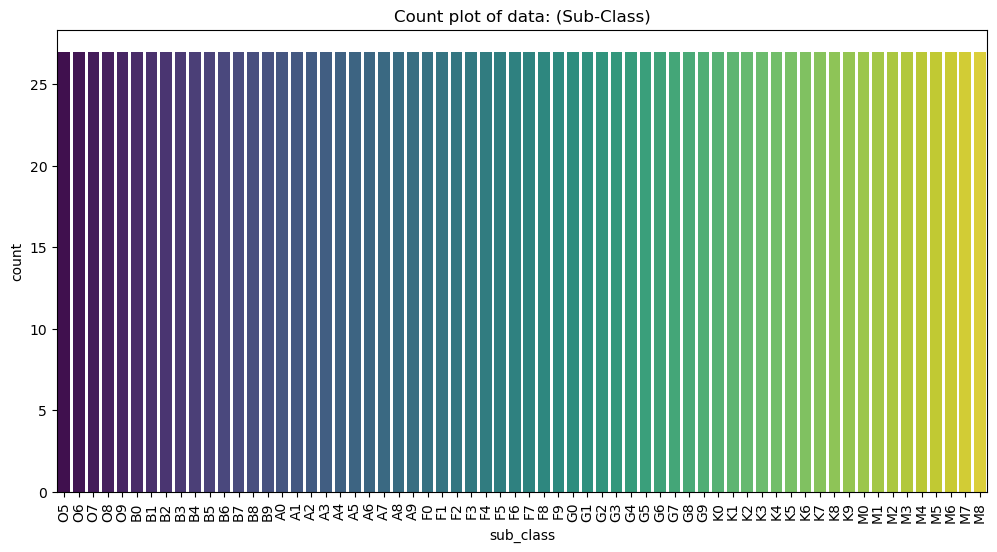

In [459]:
#having a quick look at the class balance
plt.figure(figsize=(12, 6))
sns.countplot(x='sub_class', data=sub_bal, palette='viridis')
plt.title('Count plot of balanced data: (Sub-Class)')
plt.xlabel('Sub-Class Label', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [460]:
#encoding sub class
class_order = sub_bal['sub_class'].unique()
class_mapping = {label: idx for idx, label in enumerate(class_order)}
sub_bal['sub_class'] = sub_bal['sub_class'].map(class_mapping)

In [293]:
#saving balanced dataset to csv
sub_bal.to_csv('../data/derived_tables/X_y_data/sub_bal.csv')

## 11.2 Balancing the dataset for the main class classification models

In [461]:
main_class_counts = all_spec['main_class'].value_counts()

all_spec['main_class_counts'] = pd.Categorical(all_spec['main_class'], categories=main_class_counts.index, ordered=True)

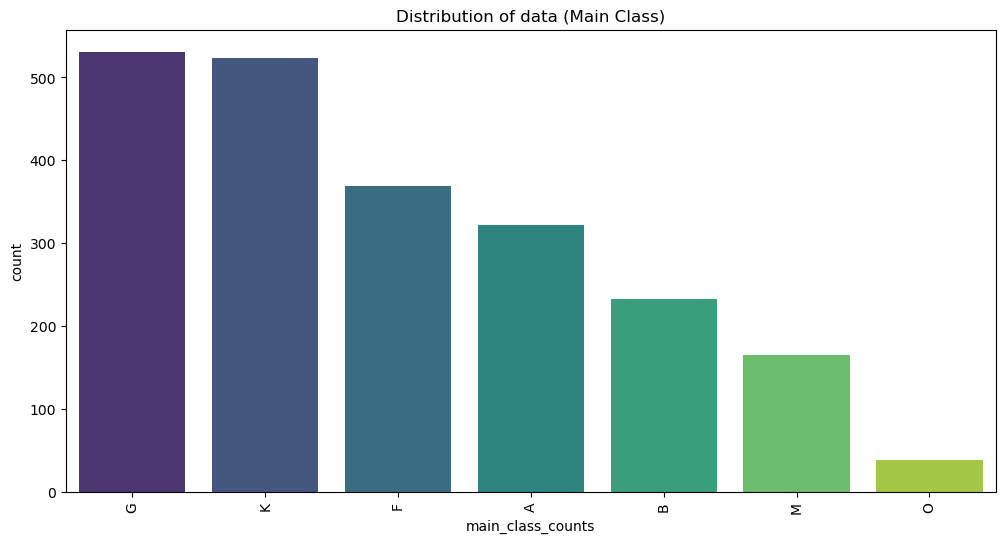

In [462]:
#having a quick look at the class balance
plt.figure(figsize=(12, 6))
sns.countplot(x='main_class_counts', data=all_spec, palette='viridis')
plt.title('Distribution of data (Main Class)')
plt.xticks(rotation=90, fontsize=10)
plt.show()

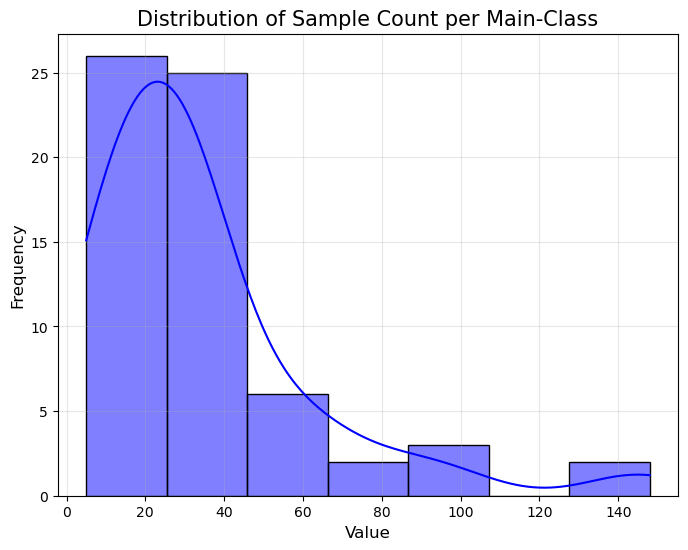

In [463]:
#plotting distribution of sample count per sub-Class
plt.figure(figsize=(8, 6))
sns.histplot(sample_counts, bins=7, kde=True, color='blue', edgecolor='black')

plt.title('Distribution of Sample Count per Main-Class', fontsize=15)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [464]:
#creating a dataframe relating to the count of each main class values
main_class_counts = all_spec['main_class'].value_counts()
main_class_counts = main_class_counts.reset_index()
main_class_counts.columns = ['main_class', 'count']

In [465]:
mean_counts = round(np.mean(main_class_counts['count']))
median_counts = round(np.median(main_class_counts['count']))
print(f'Mean number of samples for each sub class: {mean_counts}')
print(f'Median number of samples for each sub class: {median_counts}')

Mean number of samples for each sub class: 311
Median number of samples for each sub class: 322


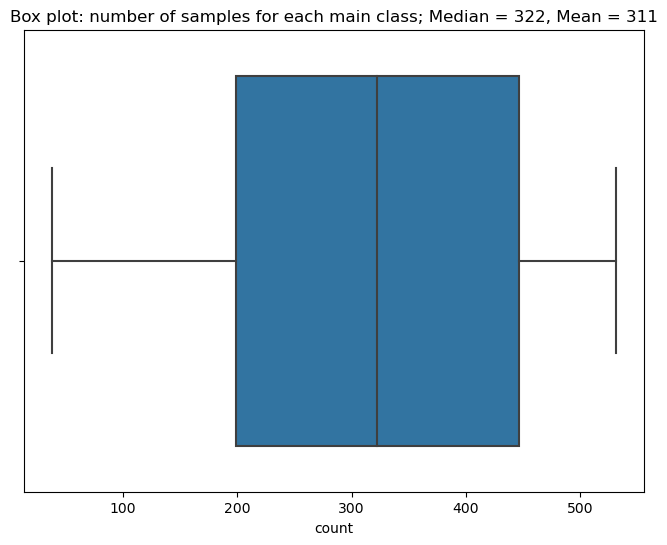

In [466]:
#creating a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=main_class_counts['count'])
plt.title('Box plot: number of samples for each main class; Median = 322, Mean = 311')
plt.show()

### 11.2.1 Undersampling majority classes down to a level that is more representative of the sample count distribution (i.e. Mean Value due to normally distributed data)

In [467]:
#getting the main, sub class and flux values
data = all_spec[['main_class', 'sub_class','flux']]

# the dataframe needs to be reformatted such that each flux value is a column
flux_data = pd.DataFrame(data['flux'].tolist(), index=data.index)
flux_data.columns = [f'flux_{i}' for i in range(flux_data.shape[1])]

data = pd.concat([data['main_class'], data['sub_class'],flux_data],axis=1)

In [468]:
main_class_bal = data.drop(columns=['sub_class'])

In [469]:
#splitting into independent/input (X) and dependent/target (Y) variables
X_main_bal = main_class_bal.loc[:, main_class_bal.columns != 'main_class']
y_main_bal = main_class_bal.loc[:, 'main_class']

In [470]:
#getting the counts in each class
class_counts = pd.Series(y_main_bal).value_counts()
#setting threshold to 311 samples
threshold = 311
#creating a dictionary mapping thresholds to each sp_type
sampling_strategy = {sp_type: threshold for sp_type in class_counts[class_counts > threshold].index}

In [471]:
#initialising the randomUnderSampler
rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)

In [472]:
#fitting the undersamplers
X_main_bal, y_main_bal = rus.fit_resample(X_main_bal, y_main_bal)

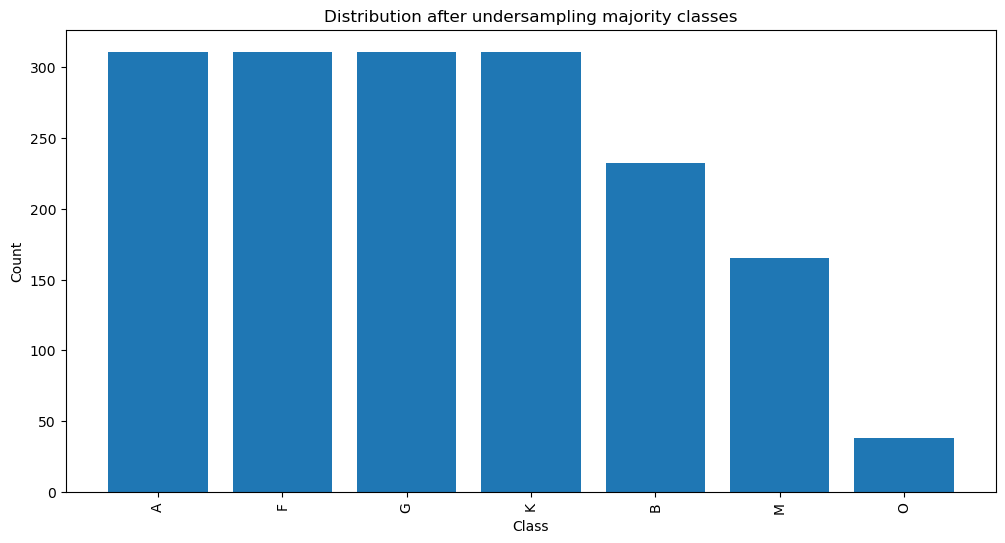

In [473]:
main_class_counts = y_main_bal.value_counts()

classes = main_class_counts.index
counts = main_class_counts.values

# Plot
plt.figure(figsize=(12, 6))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution after undersampling majority classes')
plt.xticks(rotation=90)
plt.show()

### 11.2.2 Utilising SMOTE oversampling technique to balance the minority classes

In [474]:
# transform the dataset
oversample = SMOTE(random_state = 42, k_neighbors=3)
X_main_bal, y_main_bal = oversample.fit_resample(X_main_bal, y_main_bal)

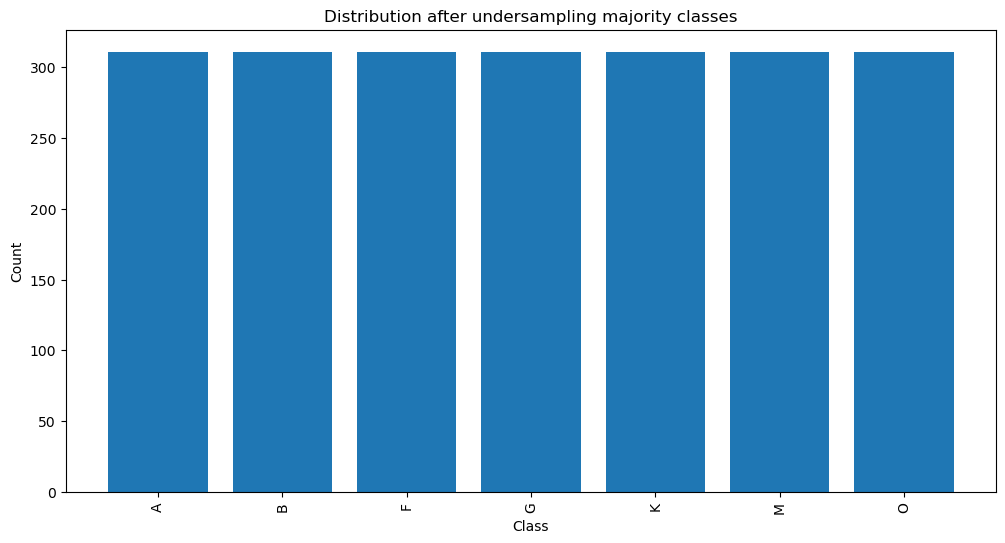

In [475]:
main_class_counts = y_main_bal.value_counts()

classes = main_class_counts.index
counts = main_class_counts.values

# Plot
plt.figure(figsize=(12, 6))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution after undersampling majority classes')
plt.xticks(rotation=90)
plt.show()

In [476]:
#merging X and y for simplicity in terms of saving 
main_bal = pd.merge(y_main_bal, X_main_bal, left_index=True, right_index=True)

In [477]:
#reordering to original ordering (i.e O -> B -> A etc.)
order = main_class['main_class'].unique()
main_bal['main_class'] = pd.Categorical(main_bal['main_class'], categories=order, ordered=True)
main_bal = main_bal.sort_values('main_class').reset_index(drop=True)
main_bal['main_class'] = main_bal['main_class'].astype('object')

In [478]:
#encoding sub class
class_order = main_bal['main_class'].unique()
class_mapping = {label: idx for idx, label in enumerate(class_order)}
main_bal['main_class'] = main_bal['main_class'].map(class_mapping)

In [479]:
main_bal

,main_class,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,...,flux_3498,flux_3499,flux_3500,flux_3501,flux_3502,flux_3503,flux_3504,flux_3505,flux_3506,flux_3507
0,0,4.605089,4.621356,4.608675,4.568462,4.543619,4.567633,4.593189,4.589667,4.560406,...,0.376261,0.372452,0.370381,0.368547,0.363889,0.364978,0.369118,0.367597,0.362808,0.357745
1,0,4.238858,4.298408,4.315569,4.285335,4.200869,4.196521,4.231638,4.274996,4.276729,...,0.355180,0.354525,0.351792,0.351737,0.352567,0.351223,0.350201,0.349021,0.348816,0.349767
2,0,4.304519,4.297902,4.281478,4.276818,4.273943,4.265703,4.265053,4.274608,4.266125,...,0.356916,0.354812,0.353430,0.353917,0.353320,0.353392,0.352460,0.351867,0.352536,0.351578
3,0,4.124419,4.130609,4.130174,4.119688,4.109552,4.115576,4.138294,4.136972,4.100161,...,0.328242,0.329476,0.330747,0.331456,0.332043,0.332010,0.330185,0.326390,0.323175,0.321689
4,0,4.332751,4.357674,4.372367,4.341792,4.305015,4.312459,4.329091,4.342334,4.336399,...,0.340095,0.341271,0.345556,0.351137,0.353357,0.354649,0.355858,0.355806,0.355860,0.354628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2172,6,0.061919,0.063951,0.078932,0.074513,0.142602,0.072470,-0.042343,0.206975,0.212903,...,1.365658,1.369343,1.358484,1.344393,1.336800,1.339527,1.343176,1.346627,1.359862,1.376966
2173,6,0.346062,0.370630,0.400204,0.427197,0.437308,0.427181,0.415093,0.420777,0.441478,...,14.064779,14.274775,14.416247,14.375969,14.160020,13.899584,13.761129,13.838087,14.094493,14.397069
2174,6,0.201564,0.092961,0.110233,0.102794,-0.022841,-0.046001,0.065756,0.001955,0.311494,...,3.235848,3.222264,3.272170,3.310089,3.195775,2.929537,2.947353,3.268007,3.371461,3.284036
2175,6,0.110838,0.121130,0.089018,0.133655,0.151900,0.147335,0.124529,0.130002,0.144437,...,2.583928,2.550801,2.497483,2.491662,2.516649,2.537638,2.565397,2.592539,2.586075,2.568591


In [325]:
#saving balanced dataset to csv
#main_bal.to_csv('../data/derived_tables/X_y_data/main_bal.csv')

__________________
# 12.  Prepping the SDSS Data:

In [326]:
##load in cleaned and processed data
sdss_spec = pd.read_pickle('../data/derived_tables/sdss_spec.pkl')

In [327]:
sdss_spec.head()

,snr,sub_class,main_class,programname,flux
specobjid,,,,,
1.846636e+18,38.89043,O,O,taurus,"[4.612751210647519, 4.629188518224726, 4.63343..."
1.846638e+18,27.32537,O,O,taurus,"[4.476836272113831, 4.496674572533562, 4.48187..."
3.116619e+18,42.14191,O,O,legacy,"[2.1434768984580406, 2.1231876404449403, 2.102..."
3.300283e+17,50.19657,B9,B,legacy,"[2.9838828817602843, 2.9883413331883526, 2.997..."
6.655341e+17,55.78799,B9,B,legacy,"[3.127076467409219, 3.128648194847776, 3.13466..."


In [328]:
#dropping unnecessary columns
sdss_spec = sdss_spec.drop(columns = ['programname'])

In [329]:
#reordering subclass in order according to MK classes
MK_main_class = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
sdss_spec['main_class'] = pd.Categorical(sdss_spec['main_class'], categories=MK_main_class, ordered=True)

#creating a new column with subclass number for sorting
sdss_spec['sub_class_number'] = sdss_spec['sub_class'].str.extract('(\d+)')

In [330]:
sdss_spec['sub_class'].unique()

array(['O', 'B9', 'B6', 'A0', 'F5', 'F9', 'F2', 'G2', 'G0', 'K7', 'K3',
       'K5', 'K1', 'M0', 'M2', 'M1', 'M3', 'M4'], dtype=object)

In [331]:
#creating an number value for each main_class category for sorting
sdss_spec['main_class_order'] = sdss_spec['main_class'].apply(lambda x: MK_main_class.index(x))

In [332]:
sdss_spec.reset_index()

,specobjid,snr,sub_class,main_class,flux,sub_class_number,main_class_order
0,1.846636e+18,38.89043,O,O,"[4.612751210647519, 4.629188518224726, 4.63343...",NaN,0
1,1.846638e+18,27.32537,O,O,"[4.476836272113831, 4.496674572533562, 4.48187...",NaN,0
2,3.116619e+18,42.14191,O,O,"[2.1434768984580406, 2.1231876404449403, 2.102...",NaN,0
3,3.300283e+17,50.19657,B9,B,"[2.9838828817602843, 2.9883413331883526, 2.997...",9,1
4,6.655341e+17,55.78799,B9,B,"[3.127076467409219, 3.128648194847776, 3.13466...",9,1
...,...,...,...,...,...,...,...
957,3.315822e+18,39.24155,M2,M,"[0.2548207636546007, 0.26685110343798474, 0.28...",2,6
958,3.501635e+18,65.74077,M2,M,"[0.22345661017502155, 0.22496517549537903, 0.2...",2,6
959,3.516212e+18,57.49692,M4,M,"[0.7324679033247589, 0.7446446997206322, 0.746...",4,6
960,3.547712e+18,38.91023,M0,M,"[0.03849859919072604, 0.05634214422168708, 0.0...",0,6


In [333]:
#ordering by main_class then sub_class
sdss_spec = sdss_spec.sort_values(by=['main_class_order', 'sub_class_number'])

In [334]:
sdss_spec = sdss_spec.drop(columns=['sub_class_number', 'main_class_order'])

In [335]:
sdss_spec = sdss_spec.reset_index()
sdss_spec= sdss_spec.drop(columns=['specobjid'])

In [336]:
sdss_spec['main_class'] = sdss_spec['main_class'].astype(str)

In [337]:
sdss_spec.head()

,snr,sub_class,main_class,flux
0,38.89043,O,O,"[4.612751210647519, 4.629188518224726, 4.63343..."
1,27.32537,O,O,"[4.476836272113831, 4.496674572533562, 4.48187..."
2,42.14191,O,O,"[2.1434768984580406, 2.1231876404449403, 2.102..."
3,47.44490,B6,B,"[2.31914144769724, 2.320970624186021, 2.322630..."
4,35.68031,B6,B,"[1.0762664420505388, 1.0724187068247237, 1.069..."


## 12.1 Preparation SDSS for main class classification

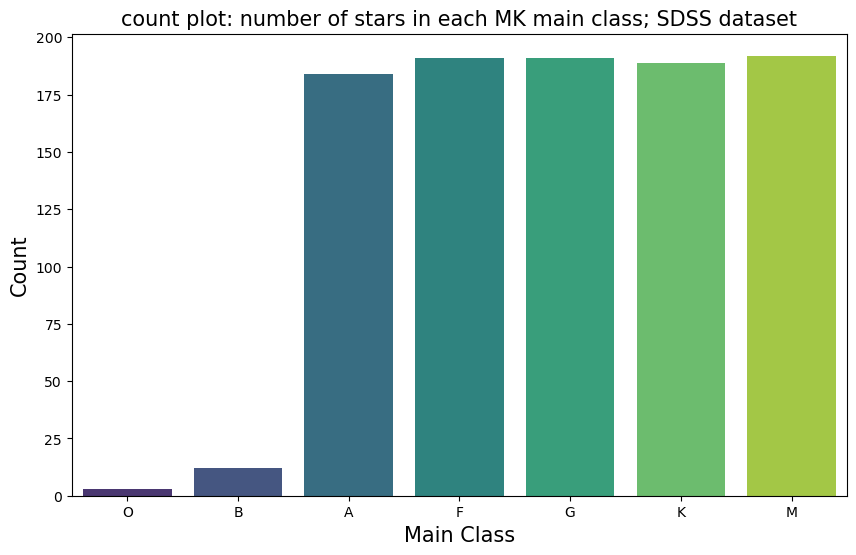

In [340]:
#having a quick look at the class balance
plt.figure(figsize=(10, 6))
sns.countplot(x='main_class', data=sdss_spec, palette='viridis')
plt.title('count plot: number of stars in each MK main class; SDSS dataset', fontsize=15)
plt.xlabel('Main Class', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

In [341]:
##reformatting the data so it can be used to train each model
#selecting the two columns required for these models
main_class = sdss_spec[['main_class','flux']]

#since each flux value is an individual feature, the dataframe needs to be reformatted such that each flux value is a column
flux_data = pd.DataFrame(main_class['flux'].tolist(), index=main_class.index)
flux_data.columns = [f'flux_{i}' for i in range(flux_data.shape[1])]

main_class = pd.concat([main_class['main_class'],flux_data],axis=1)
main_class.head()

,main_class,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,...,flux_3498,flux_3499,flux_3500,flux_3501,flux_3502,flux_3503,flux_3504,flux_3505,flux_3506,flux_3507
0,O,4.612751,4.629189,4.633437,4.622186,4.608599,4.597950,4.585971,4.575353,4.570194,...,0.193636,0.202376,0.212885,0.222521,0.229137,0.231363,0.229384,0.224177,0.217300,0.209690
1,O,4.476836,4.496675,4.481870,4.430263,4.373076,4.344155,4.354936,4.389069,4.414980,...,0.262390,0.255652,0.249205,0.244060,0.240372,0.238209,0.238330,0.241704,0.249239,0.260263
2,O,2.143477,2.123188,2.102329,2.096095,2.105726,2.121027,2.127164,2.114831,2.096489,...,0.533097,0.531302,0.528643,0.525355,0.521910,0.518842,0.516595,0.515392,0.515187,0.515745
3,B,2.319141,2.320971,2.322630,2.329044,2.342198,2.358534,2.377553,2.401723,2.426607,...,0.555787,0.555670,0.555452,0.555028,0.554267,0.553063,0.551397,0.549396,0.547353,0.545647
4,B,1.076266,1.072419,1.069726,1.077788,1.092809,1.102694,1.109586,1.119324,1.124978,...,0.699370,0.699333,0.700953,0.703704,0.706699,0.709047,0.710228,0.710135,0.709088,0.707500


In [342]:
main_class.shape

(962, 3509)

### 12.1.1 Encoding and saving X and y for main class classification:

In [343]:
encoded_data = main_class.copy()

In [344]:
class_order = encoded_data['main_class'].unique()

In [345]:
class_mapping = {label: idx for idx, label in enumerate(class_order)}

In [346]:
encoded_data['main_class'] = encoded_data['main_class'].map(class_mapping)

In [347]:
encoded_data['main_class'].unique()

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [348]:
encoded_data.to_csv('../data/derived_tables/X_y_data/sdss_main.csv')

## 12.2 Preparing SDSS data for sub-class classification:

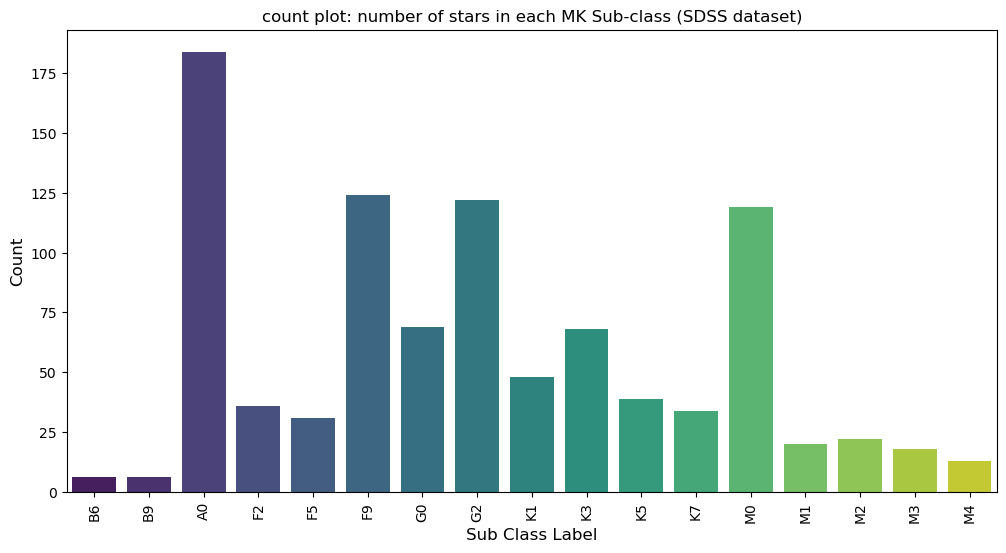

In [349]:
#having a quick look at the class balance
plt.figure(figsize=(12, 6))
sns.countplot(x='sub_class', data=sdss_spec[sdss_spec['sub_class']!='O'], palette='viridis')
plt.title('count plot: number of stars in each MK Sub-class (SDSS dataset)')
plt.xlabel('Sub Class Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [350]:
##reformatting the data so it can be used to train each model
#selecting the two columns required for these models
sub_class = sdss_spec[['sub_class','flux']]

#since each flux value is an individual feature, the dataframe needs to be reformatted such that each flux value is a column
flux_data = pd.DataFrame(sub_class['flux'].tolist(), index=sub_class.index)
flux_data.columns = [f'flux_{i}' for i in range(flux_data.shape[1])]

sub_class = pd.concat([sub_class['sub_class'],flux_data],axis=1)
sub_class.head()

,sub_class,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,...,flux_3498,flux_3499,flux_3500,flux_3501,flux_3502,flux_3503,flux_3504,flux_3505,flux_3506,flux_3507
0,O,4.612751,4.629189,4.633437,4.622186,4.608599,4.597950,4.585971,4.575353,4.570194,...,0.193636,0.202376,0.212885,0.222521,0.229137,0.231363,0.229384,0.224177,0.217300,0.209690
1,O,4.476836,4.496675,4.481870,4.430263,4.373076,4.344155,4.354936,4.389069,4.414980,...,0.262390,0.255652,0.249205,0.244060,0.240372,0.238209,0.238330,0.241704,0.249239,0.260263
2,O,2.143477,2.123188,2.102329,2.096095,2.105726,2.121027,2.127164,2.114831,2.096489,...,0.533097,0.531302,0.528643,0.525355,0.521910,0.518842,0.516595,0.515392,0.515187,0.515745
3,B6,2.319141,2.320971,2.322630,2.329044,2.342198,2.358534,2.377553,2.401723,2.426607,...,0.555787,0.555670,0.555452,0.555028,0.554267,0.553063,0.551397,0.549396,0.547353,0.545647
4,B6,1.076266,1.072419,1.069726,1.077788,1.092809,1.102694,1.109586,1.119324,1.124978,...,0.699370,0.699333,0.700953,0.703704,0.706699,0.709047,0.710228,0.710135,0.709088,0.707500


In [351]:
#dropping where sub_class = 'O' as these values dont correspond to an MK sub class
sub_class = sub_class[sub_class['sub_class']!='O']
sub_class = sub_class.reset_index().drop(columns=['index'])

In [352]:
sub_class.head()

,sub_class,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,...,flux_3498,flux_3499,flux_3500,flux_3501,flux_3502,flux_3503,flux_3504,flux_3505,flux_3506,flux_3507
0,B6,2.319141,2.320971,2.322630,2.329044,2.342198,2.358534,2.377553,2.401723,2.426607,...,0.555787,0.555670,0.555452,0.555028,0.554267,0.553063,0.551397,0.549396,0.547353,0.545647
1,B6,1.076266,1.072419,1.069726,1.077788,1.092809,1.102694,1.109586,1.119324,1.124978,...,0.699370,0.699333,0.700953,0.703704,0.706699,0.709047,0.710228,0.710135,0.709088,0.707500
2,B6,2.799091,2.810997,2.819013,2.831406,2.857356,2.896342,2.940334,2.977965,2.998614,...,0.508048,0.505507,0.503807,0.503198,0.503417,0.503989,0.504419,0.504406,0.503886,0.502886
3,B6,2.514566,2.542403,2.549494,2.541632,2.532339,2.526428,2.526824,2.536020,2.552435,...,0.526584,0.526495,0.526734,0.527488,0.528404,0.528879,0.528241,0.526183,0.522896,0.518998
4,B6,1.694404,1.718009,1.747110,1.776658,1.800411,1.815148,1.826831,1.839704,1.849551,...,0.474820,0.474415,0.473456,0.472040,0.470516,0.469306,0.468764,0.468992,0.469801,0.470964


### 12.2.1 Encoding and saving X and y for sub-class classification. 
**Need to ensure these values are encoded such that each sub class corresponds to the same integer from the training data sets since the SDSS data is not complete between subsequent subclasses.**

In [353]:
encoded_data = sub_class.copy()

In [354]:
encoded_data['sub_class'] = encoded_data['sub_class'].map(class_mapping_sub_class)

In [355]:
encoded_data.head()

,sub_class,flux_0,flux_1,flux_2,flux_3,flux_4,flux_5,flux_6,flux_7,flux_8,...,flux_3498,flux_3499,flux_3500,flux_3501,flux_3502,flux_3503,flux_3504,flux_3505,flux_3506,flux_3507
0,11,2.319141,2.320971,2.322630,2.329044,2.342198,2.358534,2.377553,2.401723,2.426607,...,0.555787,0.555670,0.555452,0.555028,0.554267,0.553063,0.551397,0.549396,0.547353,0.545647
1,11,1.076266,1.072419,1.069726,1.077788,1.092809,1.102694,1.109586,1.119324,1.124978,...,0.699370,0.699333,0.700953,0.703704,0.706699,0.709047,0.710228,0.710135,0.709088,0.707500
2,11,2.799091,2.810997,2.819013,2.831406,2.857356,2.896342,2.940334,2.977965,2.998614,...,0.508048,0.505507,0.503807,0.503198,0.503417,0.503989,0.504419,0.504406,0.503886,0.502886
3,11,2.514566,2.542403,2.549494,2.541632,2.532339,2.526428,2.526824,2.536020,2.552435,...,0.526584,0.526495,0.526734,0.527488,0.528404,0.528879,0.528241,0.526183,0.522896,0.518998
4,11,1.694404,1.718009,1.747110,1.776658,1.800411,1.815148,1.826831,1.839704,1.849551,...,0.474820,0.474415,0.473456,0.472040,0.470516,0.469306,0.468764,0.468992,0.469801,0.470964


In [356]:
encoded_data['sub_class'].unique()

array([11, 14, 15, 27, 30, 34, 35, 37, 46, 48, 50, 52, 55, 56, 57, 58, 59],
      dtype=int64)

In [357]:
#number of categories
len(encoded_data['sub_class'].unique())

17

In [358]:
#saving X and y to csvs
encoded_data.to_csv('../data/derived_tables/X_y_data/sdss_sub.csv')